다양한 기계학습 방법을 통해 online 뉴스 인기도 예측력를 극대화
 
최종 평가는 아래 test 데이터를 활용, 최종 예측 평가 지표는 MAE (Mean Absolute Error).

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from graphviz import Source
from IPython.display import Image
from sklearn.tree import export_graphviz

#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## for classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

## for regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

sns.set_style("whitegrid")

In [15]:
# from google.colab import drive
# drive.mount('/content/drive')

In [34]:
path = "onlinenews.csv"
data = pd.read_csv(path, engine='python')
print("- Data has {} rows and {} columns.".format(*data.shape))
print("- Column names: ", list(data.columns))

X = data.drop([' shares'], axis=1)
y = data[' shares']

- Data has 39644 rows and 60 columns.
- Column names:  [' timedelta', ' n_tokens_title', ' n_tokens_content', ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens', ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos', ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle', ' data_channel_is_entertainment', ' data_channel_is_bus', ' data_channel_is_socmed', ' data_channel_is_tech', ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min', ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg', ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares', ' self_reference_max_shares', ' self_reference_avg_sharess', ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday', ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday', ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02', ' LDA_03', ' LDA_04', ' global_subjectivity', ' global_sentiment_polarity', ' global_rate_positive_words', ' global

데이터 6:2:2 Train valid test 구분

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=2015010720)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      test_size=0.25,
                                                      random_state=2015010720)

# X_valid = scaler.transform(X_valid)

최적 파라미터 조정 없이 학습 및 테스트 진행

In [194]:
clf_dt = DecisionTreeRegressor(criterion='squared_error', max_depth=None)
clf_dt.fit(X_train, y_train)
y_train_pred = clf_dt.predict(X_train)
y_valid_pred = clf_dt.predict(X_valid)
y_test_pred = clf_dt.predict(X_test)

In [195]:
# Show train & validation accuracies
print('- MSE (Train)      : {:.4}'.format(mean_squared_error(y_train, y_train_pred)))
print('- MSE (Validation) : {:.4}'.format(mean_squared_error(y_valid, y_valid_pred)))
print('- MSE (test) : {:.4}'.format(mean_squared_error(y_test, y_test_pred)))
print('- MAE (Train)      : {:.4}'.format(mean_absolute_error(y_train, y_train_pred)))
print('- MAE (Validation) : {:}'.format(round(mean_absolute_error(y_valid, y_valid_pred))))
print('- MAE (Validation) : {:}'.format(round(mean_absolute_error(y_test, y_test_pred))))

- MSE (Train)      : 0.0
- MSE (Validation) : 2.854e+08
- MSE (test) : 3.916e+08
- MAE (Train)      : 0.0
- MAE (Validation) : 4283
- MAE (Validation) : 4441


---

### 피처 엔지니어링

In [36]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.ensemble import RandomForestRegressor

# 분할된 각각의 세트에 동일한 피처 엔지니어링 함수 정의
def engineer_features(df):
    df = df.copy()
    # 2-1) 고왜도 컬럼 찾아서 √, ³√ 추가
    skews = df.skew().abs()
    high_skew = skews[skews > 1].index
    for col in high_skew:
        df[f"{col}_sqrt"] = np.sqrt(df[col])
        df[f"{col}_cbrt"] = np.cbrt(df[col])
    # 2-2) 상위 5개 왜도 컬럼 간 곱셈·나눗셈 항 추가
    top5 = list(high_skew.sort_values(ascending=False)[:5])
    for i, a in enumerate(top5):
        for b in top5[i+1:]:
            df[f"{a}_x_{b}"] = df[a] * df[b]
            df[f"{a}_div_{b}"] = np.where(df[b]==0, 0, df[a] / df[b])

            # 클리핑
            low, high = np.percentile(df[f"{a}_div_{b}"], [0.1, 99.9])
            df[f"{a}_div_{b}"] = df[f"{a}_div_{b}"].clip(low, high)

    return df

# 각 세트에 피처 엔지니어링 적용
X_train_fe = engineer_features(X_train)
X_valid_fe = engineer_features(X_valid)
X_test_fe  = engineer_features(X_test)

# 결측치 대체 — 중앙값으로
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train_fe)
X_valid_imp = imputer.transform(X_valid_fe)
X_test_imp  = imputer.transform(X_test_fe)

# DataFrame 형태로 복원
X_train_df = pd.DataFrame(X_train_imp, columns=X_train_fe.columns, index=X_train.index)
X_valid_df = pd.DataFrame(X_valid_imp, columns=X_train_fe.columns, index=X_valid.index)
X_test_df  = pd.DataFrame(X_test_imp,  columns=X_train_fe.columns, index=X_test.index)


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3736145416.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{a}_x_{b}"] = df[a] * df[b]

---

### EDA

In [197]:
# 기초 통계 및 결측치 확인
print("=== X 요약 통계 ===")
print(X.describe().T)
print("\n=== y 요약 통계 ===")
print(y.describe())
print("\n=== 결측치 개수 ===")
na_X = X.isna().sum()
na_y = pd.Series({'y': y.isna().sum()})
print(pd.concat([na_X, na_y], axis=1, keys=['X','y']))

=== X 요약 통계 ===
                                 count           mean            std      min  \
timedelta                      39644.0     354.530471     214.163767  8.00000   
n_tokens_title                 39644.0      10.398749       2.114037  2.00000   
n_tokens_content               39644.0     546.514731     471.107508  0.00000   
n_unique_tokens                39644.0       0.548216       3.520708  0.00000   
n_non_stop_words               39644.0       0.996469       5.231231  0.00000   
n_non_stop_unique_tokens       39644.0       0.689175       3.264816  0.00000   
num_hrefs                      39644.0      10.883690      11.332017  0.00000   
num_self_hrefs                 39644.0       3.293638       3.855141  0.00000   
num_imgs                       39644.0       4.544143       8.309434  0.00000   
num_videos                     39644.0       1.249874       4.107855  0.00000   
average_token_length           39644.0       4.548239       0.844406  0.00000   
num_keywords

Skewness of y: 33.9639


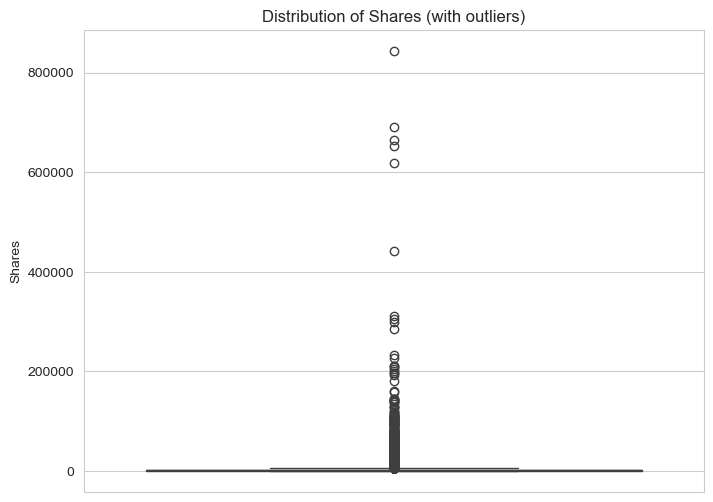

In [198]:
# y 왜도 계산 및 이상치 파악 (전체)
skewness = y.skew()
print(f'Skewness of y: {skewness:.4f}')
      
plt.figure(figsize=(8, 6))
sns.boxplot(y=y)
plt.title('Distribution of Shares (with outliers)')
plt.ylabel('Shares')
plt.show()


=== X feature skewness ===
n_non_stop_words                 198.792445
n_unique_tokens                  198.655116
n_non_stop_unique_tokens         198.443294
kw_max_min                        35.328434
kw_avg_min                        31.306108
self_reference_min_shares         26.264364
self_reference_avg_sharess        17.914093
kw_max_avg                        16.411670
self_reference_max_shares         13.870849
kw_min_max                        10.386372
num_videos                         7.019533
kw_avg_avg                         5.760177
num_self_hrefs                     5.172751
num_hrefs                          4.013495
data_channel_is_lifestyle          3.993019
num_imgs                           3.946596
data_channel_is_socmed             3.758880
weekday_is_saturday                3.637086
weekday_is_sunday                  3.399927
min_positive_polarity              3.040468
n_tokens_content                   2.945422
kw_min_min                         2.374947
is_w

/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_77476/3812532366.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=skewness.values, y=skewness.index, palette='viridis')


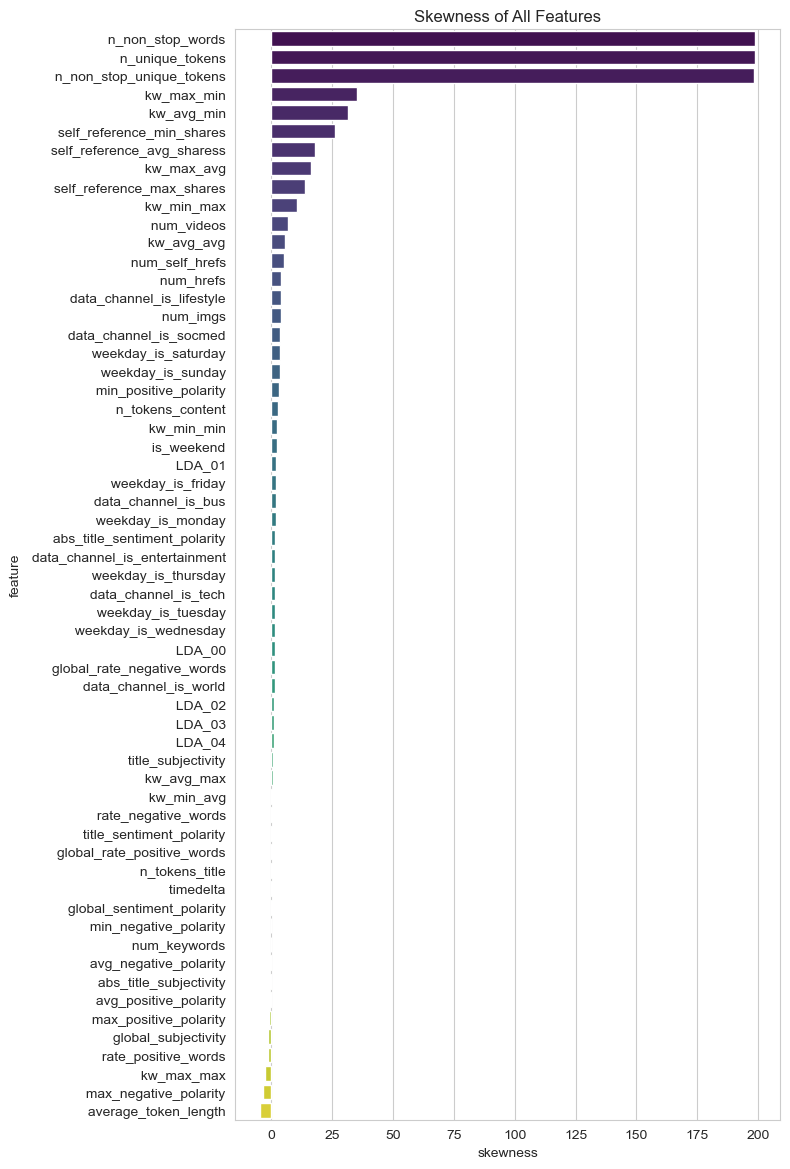

In [199]:
# X 모든 특성의 왜도 계산 및 시각화 (전체)
skewness = X.skew().sort_values(ascending=False)
print("\n=== X feature skewness ===")
print(skewness)
plt.figure(figsize=(8, len(skewness)*0.2))
sns.barplot(x=skewness.values, y=skewness.index, palette='viridis')
plt.title('Skewness of All Features')
plt.xlabel('skewness')
plt.ylabel('feature')
plt.tight_layout()
plt.show()

### 모델 + 이상치제거, x,y 로그변환, PowerTransformer 조합 분석

In [37]:
from sklearn.base import clone
from tqdm import tqdm
from sklearn.preprocessing import PowerTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    AdaBoostRegressor
)

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


# 1) 실행할 모델 정의
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'KNeighbors': KNeighborsRegressor(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'ExtraTrees': ExtraTreesRegressor(n_estimators=50, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=50, random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'HistGradientBoosting': HistGradientBoostingRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(random_state=42, verbosity=0),
    'LGBMRegressor': LGBMRegressor(random_state=42),
    'CatBoostRegressor': CatBoostRegressor(random_state=42, verbose=False)
}

# 2) 전처리 조합 리스트 (use_log: x+y 로그 변환, use_pt: PowerTransformer)
combos = [
    {'name': 'raw',                  'remove_pct': None,    'use_iqr': False, 'use_log': False, 'use_pt': False},
    {'name': 'logXY',                'remove_pct': None,    'use_iqr': False, 'use_log': True,  'use_pt': False},
    {'name': 'PT only',              'remove_pct': None,    'use_iqr': False, 'use_log': False, 'use_pt': True},
    {'name': 'logXY + PT',           'remove_pct': None,    'use_iqr': False, 'use_log': True,  'use_pt': True},
    {'name': 'remove 1%',            'remove_pct': 0.99,    'use_iqr': False, 'use_log': False, 'use_pt': False},
    {'name': 'remove 1% + logXY',    'remove_pct': 0.99,    'use_iqr': False, 'use_log': True,  'use_pt': False},
    {'name': 'remove 1% + PT',       'remove_pct': 0.99,    'use_iqr': False, 'use_log': False, 'use_pt': True},
    {'name': 'remove 1% + logXY+PT', 'remove_pct': 0.99,    'use_iqr': False, 'use_log': True,  'use_pt': True},
    {'name': 'remove 0.5%',          'remove_pct': 0.995,   'use_iqr': False, 'use_log': False, 'use_pt': False},
    {'name': 'remove 0.5%+logXY',    'remove_pct': 0.995,   'use_iqr': False, 'use_log': True,  'use_pt': False},
    {'name': 'remove 0.5%+PT',       'remove_pct': 0.995,   'use_iqr': False, 'use_log': False, 'use_pt': True},
    {'name': 'remove0.5%+logXY+PT',  'remove_pct': 0.995,   'use_iqr': False, 'use_log': True,  'use_pt': True},
    {'name': 'IQR',                  'remove_pct': None,    'use_iqr': True,  'use_log': False, 'use_pt': False},
    {'name': 'IQR + logXY',          'remove_pct': None,    'use_iqr': True,  'use_log': True,  'use_pt': False},
    {'name': 'IQR + PT',             'remove_pct': None,    'use_iqr': True,  'use_log': False, 'use_pt': True},
    {'name': 'IQR+logXY+PT',         'remove_pct': None,    'use_iqr': True,  'use_log': True,  'use_pt': True}
]

# 3) 전처리·평가 함수 (이상치제거 → x/y 로그 → PT → 학습 → y 복원 → 평가)
def preprocess_and_eval(model, X_tr, y_tr, X_te, y_te,
                        remove_pct=None, use_iqr=False,
                        use_log=False, use_pt=False):
    Xc, yc = X_tr.copy(), y_tr.copy()

    # 1) 이상치 제거 (y 기준)
    if use_iqr:
        Q1, Q3 = np.percentile(yc, [25, 75])
        mask = (yc >= Q1 - 1.5*(Q3-Q1)) & (yc <= Q3 + 1.5*(Q3-Q1))
        Xc, yc = Xc[mask], yc[mask]
    elif remove_pct is not None:
        thresh = np.percentile(yc, remove_pct*100)
        mask = yc <= thresh
        Xc, yc = Xc[mask], yc[mask]

    # 2) 로그 변환 (x는 skew>1 & non-negative 컬럼만, y 전체)
    if use_log:
        # y 로그
        yc = np.log1p(yc)
        # x selective 로그
        skew_cols = Xc.columns[(Xc.skew().abs() > 1) & (Xc.min() >= 0)]
        Xc[skew_cols] = np.log1p(Xc[skew_cols])
        Xc = np.nan_to_num(Xc, neginf=0, posinf=0)

    # 3) PowerTransformer (x)
    if use_pt:
        pt = PowerTransformer(method='yeo-johnson')
        Xc = pt.fit_transform(Xc)
        Xc = np.nan_to_num(Xc, neginf=0, posinf=0)
        # test에도 동일 변환
        Xte = X_te.copy()
        if use_log:
            Xte[skew_cols] = np.log1p(Xte[skew_cols])
        Xte = pt.transform(np.nan_to_num(Xte, neginf=0, posinf=0))
    else:
        Xte = X_te.copy()
        if use_log:
            Xte[skew_cols] = np.log1p(Xte[skew_cols])
            Xte = np.nan_to_num(Xte, neginf=0, posinf=0)


    # 4) 학습·예측
    clf = clone(model)
    clf.fit(Xc, yc)
    y_pred_log = clf.predict(Xte)

    # 5) y 복원
    if use_log:
        y_pred = np.expm1(y_pred_log)
    else:
        y_pred = y_pred_log

    # 6) 평가
    return mean_squared_error(y_te, y_pred), mean_absolute_error(y_te, y_pred)

# 4) 일괄 실행 및 결과 수집
results = []
for model_name, model in models.items():
    print(f'\n=== {model_name} ===')
    for combo in tqdm(combos, desc=model_name):
        mse, mae = preprocess_and_eval(
            model, 
            # X_train,
            X_train_df,
            y_train, 
            # X_test, 
            X_test_df,
            y_test,
            remove_pct=combo['remove_pct'],
            use_iqr=combo['use_iqr'],
            use_log=combo['use_log'],
            use_pt=combo['use_pt']
        )
        print(f"{combo['name']:20s} → MSE: {mse:.4e}, MAE: {mae:.4f}")
        results.append({
            'model': model_name,
            'combo': combo['name'],
            'MSE': mse,
            'MAE': mae
        })

# 5) DataFrame 변환, MAE 기준 정렬
df = pd.DataFrame(results).sort_values(by='MAE', ascending=True)


=== LinearRegression ===


LinearRegression:   6%|▋         | 1/16 [00:00<00:02,  5.71it/s]

raw                  → MSE: 1.4565e+08, MAE: 3134.6631


LinearRegression:  12%|█▎        | 2/16 [00:00<00:02,  5.27it/s]

logXY                → MSE: 1.5198e+08, MAE: 2364.2544


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
LinearRegression:  19%|█▉        | 3/16 [00:01<00:08,  1.45it/s]

PT only              → MSE: 1.4624e+08, MAE: 3173.1492


LinearRegression:  31%|███▏      | 5/16 [00:02<00:06,  1.71it/s]

logXY + PT           → MSE: 1.4825e+08, MAE: 2343.1265
remove 1%            → MSE: 1.4571e+08, MAE: 2614.2614


LinearRegression:  38%|███▊      | 6/16 [00:03<00:04,  2.17it/s]

remove 1% + logXY    → MSE: 2.4794e+08, MAE: 2442.1258


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
LinearRegression:  44%|████▍     | 7/16 [00:04<00:05,  1.58it/s]

remove 1% + PT       → MSE: 1.4579e+08, MAE: 2612.5535


LinearRegression:  56%|█████▋    | 9/16 [00:05<00:03,  1.82it/s]

remove 1% + logXY+PT → MSE: 1.4874e+08, MAE: 2330.9862
remove 0.5%          → MSE: 1.4526e+08, MAE: 2707.8377


LinearRegression:  62%|██████▎   | 10/16 [00:05<00:02,  2.21it/s]

remove 0.5%+logXY    → MSE: 1.5776e+08, MAE: 2369.5837


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
LinearRegression:  69%|██████▉   | 11/16 [00:06<00:03,  1.61it/s]

remove 0.5%+PT       → MSE: 1.4537e+08, MAE: 2706.2621


LinearRegression:  81%|████████▏ | 13/16 [00:07<00:01,  1.80it/s]

remove0.5%+logXY+PT  → MSE: 1.4854e+08, MAE: 2336.2229
IQR                  → MSE: 1.4983e+08, MAE: 2342.7654


LinearRegression:  88%|████████▊ | 14/16 [00:07<00:00,  2.20it/s]

IQR + logXY          → MSE: 2.0305e+08, MAE: 2409.7474


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
LinearRegression:  94%|█████████▍| 15/16 [00:08<00:00,  1.72it/s]

IQR + PT             → MSE: 1.4983e+08, MAE: 2340.3535


LinearRegression: 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


IQR+logXY+PT         → MSE: 1.5083e+08, MAE: 2330.1110

=== Ridge ===


Ridge:  12%|█▎        | 2/16 [00:00<00:01, 13.01it/s]

raw                  → MSE: 1.4544e+08, MAE: 3096.7168
logXY                → MSE: 1.4839e+08, MAE: 2346.8662


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


PT only              → MSE: 1.4543e+08, MAE: 3111.4628


Ridge:  38%|███▊      | 6/16 [00:02<00:03,  2.91it/s]

logXY + PT           → MSE: 1.4833e+08, MAE: 2345.5057
remove 1%            → MSE: 1.4571e+08, MAE: 2613.4842
remove 1% + logXY    → MSE: 1.4886e+08, MAE: 2334.9280


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
Ridge:  44%|████▍     | 7/16 [00:03<00:04,  2.10it/s]

remove 1% + PT       → MSE: 1.4585e+08, MAE: 2620.8331


Ridge:  62%|██████▎   | 10/16 [00:04<00:02,  2.76it/s]

remove 1% + logXY+PT → MSE: 1.4881e+08, MAE: 2334.0253
remove 0.5%          → MSE: 1.4528e+08, MAE: 2708.2515
remove 0.5%+logXY    → MSE: 1.4866e+08, MAE: 2340.1420


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
Ridge:  69%|██████▉   | 11/16 [00:04<00:02,  2.10it/s]

remove 0.5%+PT       → MSE: 1.4540e+08, MAE: 2715.1872


Ridge:  88%|████████▊ | 14/16 [00:05<00:00,  2.74it/s]

remove0.5%+logXY+PT  → MSE: 1.4861e+08, MAE: 2339.0107
IQR                  → MSE: 1.4984e+08, MAE: 2343.3220
IQR + logXY          → MSE: 1.5091e+08, MAE: 2333.8264


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
Ridge:  94%|█████████▍| 15/16 [00:06<00:00,  2.16it/s]

IQR + PT             → MSE: 1.4989e+08, MAE: 2347.2373


Ridge: 100%|██████████| 16/16 [00:07<00:00,  2.13it/s]


IQR+logXY+PT         → MSE: 1.5089e+08, MAE: 2333.1444

=== Lasso ===


Lasso:   0%|          | 0/16 [00:00<?, ?it/s]/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.698e+12, tolerance: 3.516e+08
  model = cd_fast.enet_coordinate_descent(
Lasso:  12%|█▎        | 2/16 [00:07<00:44,  3.15s/it]

raw                  → MSE: 1.4540e+08, MAE: 3076.1862
logXY                → MSE: 1.5016e+08, MAE: 2451.7893


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.372e+11, tolerance: 3.516e+08
  model = cd_fast.enet_coordinate_descent(
Lasso:  19%|█▉        | 3/16 [00:15<01:12,  5.54s/it]

PT only              → MSE: 1.4535e+08, MAE: 3094.8434


Lasso:  25%|██▌       | 4/16 [00:16<00:44,  3.71s/it]

logXY + PT           → MSE: 1.5039e+08, MAE: 2463.6460


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.451e+11, tolerance: 3.173e+07
  model = cd_fast.enet_coordinate_descent(
Lasso:  38%|███▊      | 6/16 [00:24<00:33,  3.34s/it]

remove 1%            → MSE: 1.4580e+08, MAE: 2613.8896
remove 1% + logXY    → MSE: 1.5041e+08, MAE: 2440.0053


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.217e+10, tolerance: 3.173e+07
  model = cd_fast.enet_coordinate_descent(
Lasso:  44%|████▍     | 7/16 [00:31<00:41,  4.66s/it]

remove 1% + PT       → MSE: 1.4599e+08, MAE: 2633.6317


Lasso:  50%|█████     | 8/16 [00:32<00:27,  3.46s/it]

remove 1% + logXY+PT → MSE: 1.5059e+08, MAE: 2451.9822


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.334e+11, tolerance: 5.059e+07
  model = cd_fast.enet_coordinate_descent(
Lasso:  62%|██████▎   | 10/16 [00:38<00:17,  2.93s/it]

remove 0.5%          → MSE: 1.4532e+08, MAE: 2706.9781
remove 0.5%+logXY    → MSE: 1.5030e+08, MAE: 2445.3367


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.856e+10, tolerance: 5.059e+07
  model = cd_fast.enet_coordinate_descent(
Lasso:  69%|██████▉   | 11/16 [00:44<00:20,  4.03s/it]

remove 0.5%+PT       → MSE: 1.4551e+08, MAE: 2724.6575


Lasso:  75%|███████▌  | 12/16 [00:45<00:12,  3.08s/it]

remove0.5%+logXY+PT  → MSE: 1.5050e+08, MAE: 2457.2591


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.128e+10, tolerance: 2.586e+06
  model = cd_fast.enet_coordinate_descent(
Lasso:  88%|████████▊ | 14/16 [00:49<00:04,  2.31s/it]

IQR                  → MSE: 1.4989e+08, MAE: 2347.4272
IQR + logXY          → MSE: 1.5170e+08, MAE: 2420.4735


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.491e+08, tolerance: 2.586e+06
  model = cd_fast.enet_coordinate_descent(
Lasso:  94%|█████████▍| 15/16 [00:54<00:02,  2.97s/it]

IQR + PT             → MSE: 1.4998e+08, MAE: 2358.8383


Lasso: 100%|██████████| 16/16 [00:54<00:00,  3.44s/it]


IQR+logXY+PT         → MSE: 1.5177e+08, MAE: 2428.6351

=== KNeighbors ===


KNeighbors:   6%|▋         | 1/16 [00:00<00:06,  2.36it/s]

raw                  → MSE: 1.5835e+08, MAE: 3230.4227


KNeighbors:  12%|█▎        | 2/16 [00:00<00:04,  2.90it/s]

logXY                → MSE: 1.5027e+08, MAE: 2582.6228


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
KNeighbors:  19%|█▉        | 3/16 [00:01<00:08,  1.52it/s]

PT only              → MSE: 1.5660e+08, MAE: 3152.1144


KNeighbors:  25%|██▌       | 4/16 [00:02<00:09,  1.24it/s]

logXY + PT           → MSE: 1.4841e+08, MAE: 2474.2281


KNeighbors:  31%|███▏      | 5/16 [00:03<00:06,  1.66it/s]

remove 1%            → MSE: 1.4965e+08, MAE: 2838.0853


KNeighbors:  38%|███▊      | 6/16 [00:03<00:04,  2.01it/s]

remove 1% + logXY    → MSE: 1.5024e+08, MAE: 2534.3912


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
KNeighbors:  44%|████▍     | 7/16 [00:04<00:06,  1.49it/s]

remove 1% + PT       → MSE: 1.4709e+08, MAE: 2707.1811


KNeighbors:  50%|█████     | 8/16 [00:05<00:06,  1.28it/s]

remove 1% + logXY+PT → MSE: 1.4864e+08, MAE: 2435.8264


KNeighbors:  56%|█████▋    | 9/16 [00:05<00:04,  1.64it/s]

remove 0.5%          → MSE: 1.5064e+08, MAE: 2963.5503


KNeighbors:  62%|██████▎   | 10/16 [00:05<00:03,  1.95it/s]

remove 0.5%+logXY    → MSE: 1.5026e+08, MAE: 2557.1855


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
KNeighbors:  69%|██████▉   | 11/16 [00:06<00:03,  1.48it/s]

remove 0.5%+PT       → MSE: 1.4789e+08, MAE: 2819.3343


KNeighbors:  75%|███████▌  | 12/16 [00:07<00:03,  1.27it/s]

remove0.5%+logXY+PT  → MSE: 1.4853e+08, MAE: 2449.2104


KNeighbors:  81%|████████▏ | 13/16 [00:08<00:01,  1.63it/s]

IQR                  → MSE: 1.5050e+08, MAE: 2450.1820


KNeighbors:  88%|████████▊ | 14/16 [00:08<00:01,  1.97it/s]

IQR + logXY          → MSE: 1.5149e+08, MAE: 2453.4059


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
KNeighbors:  94%|█████████▍| 15/16 [00:09<00:00,  1.57it/s]

IQR + PT             → MSE: 1.5023e+08, MAE: 2390.8025


KNeighbors: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


IQR+logXY+PT         → MSE: 1.5087e+08, MAE: 2384.2387

=== DecisionTree ===


DecisionTree:   6%|▋         | 1/16 [00:02<00:37,  2.48s/it]

raw                  → MSE: 3.7217e+08, MAE: 4496.9555


DecisionTree:  12%|█▎        | 2/16 [00:04<00:29,  2.08s/it]

logXY                → MSE: 2.8166e+08, MAE: 3981.0349


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
DecisionTree:  19%|█▉        | 3/16 [00:07<00:34,  2.64s/it]

PT only              → MSE: 4.7643e+08, MAE: 4714.6481


DecisionTree:  25%|██▌       | 4/16 [00:10<00:31,  2.62s/it]

logXY + PT           → MSE: 3.4124e+08, MAE: 4096.7465


DecisionTree:  31%|███▏      | 5/16 [00:12<00:26,  2.45s/it]

remove 1%            → MSE: 1.6069e+08, MAE: 3366.7118


DecisionTree:  38%|███▊      | 6/16 [00:14<00:22,  2.26s/it]

remove 1% + logXY    → MSE: 1.5858e+08, MAE: 3288.8057


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
DecisionTree:  44%|████▍     | 7/16 [00:17<00:22,  2.52s/it]

remove 1% + PT       → MSE: 1.6049e+08, MAE: 3386.5026


DecisionTree:  50%|█████     | 8/16 [00:19<00:20,  2.57s/it]

remove 1% + logXY+PT → MSE: 1.5898e+08, MAE: 3289.5986


DecisionTree:  56%|█████▋    | 9/16 [00:22<00:17,  2.48s/it]

remove 0.5%          → MSE: 1.6894e+08, MAE: 3669.2950


DecisionTree:  62%|██████▎   | 10/16 [00:24<00:13,  2.29s/it]

remove 0.5%+logXY    → MSE: 1.6989e+08, MAE: 3577.0957


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
DecisionTree:  69%|██████▉   | 11/16 [00:27<00:12,  2.54s/it]

remove 0.5%+PT       → MSE: 1.6895e+08, MAE: 3668.4381


DecisionTree:  75%|███████▌  | 12/16 [00:29<00:10,  2.55s/it]

remove0.5%+logXY+PT  → MSE: 1.7001e+08, MAE: 3559.5414


DecisionTree:  81%|████████▏ | 13/16 [00:31<00:06,  2.29s/it]

IQR                  → MSE: 1.5105e+08, MAE: 2604.5421


DecisionTree:  88%|████████▊ | 14/16 [00:33<00:04,  2.07s/it]

IQR + logXY          → MSE: 1.5075e+08, MAE: 2582.6113


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
DecisionTree:  94%|█████████▍| 15/16 [00:35<00:02,  2.18s/it]

IQR + PT             → MSE: 1.5070e+08, MAE: 2592.8170


DecisionTree: 100%|██████████| 16/16 [00:37<00:00,  2.36s/it]


IQR+logXY+PT         → MSE: 1.5086e+08, MAE: 2594.9026

=== ExtraTrees ===


ExtraTrees:   6%|▋         | 1/16 [00:18<04:39, 18.61s/it]

raw                  → MSE: 1.5494e+08, MAE: 3431.6075


ExtraTrees:  12%|█▎        | 2/16 [00:35<04:10, 17.89s/it]

logXY                → MSE: 1.4734e+08, MAE: 2358.0889


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
ExtraTrees:  19%|█▉        | 3/16 [00:56<04:06, 18.99s/it]

PT only              → MSE: 1.5574e+08, MAE: 3432.1006


ExtraTrees:  25%|██▌       | 4/16 [01:15<03:46, 18.90s/it]

logXY + PT           → MSE: 1.4761e+08, MAE: 2366.0376


ExtraTrees:  31%|███▏      | 5/16 [01:32<03:22, 18.39s/it]

remove 1%            → MSE: 1.4544e+08, MAE: 2755.9373


ExtraTrees:  38%|███▊      | 6/16 [01:49<02:58, 17.81s/it]

remove 1% + logXY    → MSE: 1.4819e+08, MAE: 2345.0243


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
ExtraTrees:  44%|████▍     | 7/16 [02:08<02:44, 18.24s/it]

remove 1% + PT       → MSE: 1.4530e+08, MAE: 2757.0700


ExtraTrees:  50%|█████     | 8/16 [02:26<02:26, 18.31s/it]

remove 1% + logXY+PT → MSE: 1.4816e+08, MAE: 2348.6129


ExtraTrees:  56%|█████▋    | 9/16 [02:45<02:09, 18.43s/it]

remove 0.5%          → MSE: 1.4557e+08, MAE: 2914.6671


ExtraTrees:  62%|██████▎   | 10/16 [03:02<01:48, 18.06s/it]

remove 0.5%+logXY    → MSE: 1.4807e+08, MAE: 2353.0853


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
ExtraTrees:  69%|██████▉   | 11/16 [03:21<01:31, 18.38s/it]

remove 0.5%+PT       → MSE: 1.4567e+08, MAE: 2898.2558


ExtraTrees:  75%|███████▌  | 12/16 [03:40<01:13, 18.48s/it]

remove0.5%+logXY+PT  → MSE: 1.4776e+08, MAE: 2350.3852


ExtraTrees:  81%|████████▏ | 13/16 [03:54<00:51, 17.26s/it]

IQR                  → MSE: 1.4956e+08, MAE: 2350.1267


ExtraTrees:  88%|████████▊ | 14/16 [04:09<00:32, 16.45s/it]

IQR + logXY          → MSE: 1.5078e+08, MAE: 2331.7341


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
ExtraTrees:  94%|█████████▍| 15/16 [04:25<00:16, 16.33s/it]

IQR + PT             → MSE: 1.4960e+08, MAE: 2355.4678


ExtraTrees: 100%|██████████| 16/16 [04:41<00:00, 17.59s/it]


IQR+logXY+PT         → MSE: 1.5077e+08, MAE: 2331.5816

=== RandomForest ===


RandomForest:   6%|▋         | 1/16 [01:21<20:26, 81.74s/it]

raw                  → MSE: 1.5664e+08, MAE: 3416.3744


RandomForest:  12%|█▎        | 2/16 [02:17<15:32, 66.62s/it]

logXY                → MSE: 1.4794e+08, MAE: 2372.4883


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
RandomForest:  19%|█▉        | 3/16 [03:38<15:48, 72.98s/it]

PT only              → MSE: 1.5684e+08, MAE: 3430.6309


RandomForest:  25%|██▌       | 4/16 [04:33<13:13, 66.10s/it]

logXY + PT           → MSE: 1.4788e+08, MAE: 2369.8289


RandomForest:  31%|███▏      | 5/16 [05:41<12:12, 66.62s/it]

remove 1%            → MSE: 1.4613e+08, MAE: 2767.2156


RandomForest:  38%|███▊      | 6/16 [06:34<10:19, 61.94s/it]

remove 1% + logXY    → MSE: 1.4857e+08, MAE: 2350.5291


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
RandomForest:  44%|████▍     | 7/16 [07:44<09:41, 64.59s/it]

remove 1% + PT       → MSE: 1.4618e+08, MAE: 2776.9177


RandomForest:  50%|█████     | 8/16 [08:39<08:13, 61.67s/it]

remove 1% + logXY+PT → MSE: 1.4847e+08, MAE: 2348.6959


RandomForest:  56%|█████▋    | 9/16 [09:50<07:31, 64.49s/it]

remove 0.5%          → MSE: 1.4642e+08, MAE: 2928.7047


RandomForest:  62%|██████▎   | 10/16 [10:43<06:06, 61.07s/it]

remove 0.5%+logXY    → MSE: 1.4825e+08, MAE: 2359.4418


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
RandomForest:  69%|██████▉   | 11/16 [11:55<05:21, 64.38s/it]

remove 0.5%+PT       → MSE: 1.4680e+08, MAE: 2936.0602


RandomForest:  75%|███████▌  | 12/16 [12:50<04:06, 61.57s/it]

remove0.5%+logXY+PT  → MSE: 1.4819e+08, MAE: 2357.5721


RandomForest:  81%|████████▏ | 13/16 [13:41<02:54, 58.16s/it]

IQR                  → MSE: 1.4962e+08, MAE: 2354.5530


RandomForest:  88%|████████▊ | 14/16 [14:25<01:48, 54.08s/it]

IQR + logXY          → MSE: 1.5082e+08, MAE: 2333.0733


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
RandomForest:  94%|█████████▍| 15/16 [15:18<00:53, 53.62s/it]

IQR + PT             → MSE: 1.4962e+08, MAE: 2354.9313


RandomForest: 100%|██████████| 16/16 [16:05<00:00, 60.35s/it]


IQR+logXY+PT         → MSE: 1.5077e+08, MAE: 2331.8279

=== AdaBoost ===


AdaBoost:   6%|▋         | 1/16 [00:07<01:45,  7.07s/it]

raw                  → MSE: 1.1863e+09, MAE: 30999.4476


AdaBoost:  12%|█▎        | 2/16 [00:15<01:46,  7.64s/it]

logXY                → MSE: 1.4656e+08, MAE: 2821.6026


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
AdaBoost:  19%|█▉        | 3/16 [00:22<01:40,  7.75s/it]

PT only              → MSE: 8.2608e+08, MAE: 26186.7801


AdaBoost:  25%|██▌       | 4/16 [00:31<01:38,  8.21s/it]

logXY + PT           → MSE: 1.4648e+08, MAE: 3011.9377


AdaBoost:  31%|███▏      | 5/16 [00:35<01:10,  6.43s/it]

remove 1%            → MSE: 1.5034e+08, MAE: 4389.1311


AdaBoost:  38%|███▊      | 6/16 [00:42<01:08,  6.86s/it]

remove 1% + logXY    → MSE: 1.4813e+08, MAE: 2469.5948


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
AdaBoost:  44%|████▍     | 7/16 [00:46<00:53,  5.93s/it]

remove 1% + PT       → MSE: 1.5034e+08, MAE: 4389.1311


AdaBoost:  50%|█████     | 8/16 [00:55<00:54,  6.76s/it]

remove 1% + logXY+PT → MSE: 1.4774e+08, MAE: 2506.8764


AdaBoost:  56%|█████▋    | 9/16 [00:58<00:40,  5.73s/it]

remove 0.5%          → MSE: 1.6157e+08, MAE: 5653.2163


AdaBoost:  62%|██████▎   | 10/16 [01:06<00:38,  6.43s/it]

remove 0.5%+logXY    → MSE: 1.4694e+08, MAE: 2657.1765


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
AdaBoost:  69%|██████▉   | 11/16 [01:12<00:31,  6.26s/it]

remove 0.5%+PT       → MSE: 1.6885e+08, MAE: 6168.0489


AdaBoost:  75%|███████▌  | 12/16 [01:21<00:28,  7.15s/it]

remove0.5%+logXY+PT  → MSE: 1.4707e+08, MAE: 2618.4494


AdaBoost:  81%|████████▏ | 13/16 [01:24<00:17,  5.81s/it]

IQR                  → MSE: 1.4904e+08, MAE: 2471.7109


AdaBoost:  88%|████████▊ | 14/16 [01:30<00:11,  5.90s/it]

IQR + logXY          → MSE: 1.5198e+08, MAE: 2412.1202


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
AdaBoost:  94%|█████████▍| 15/16 [01:36<00:05,  5.81s/it]

IQR + PT             → MSE: 1.4875e+08, MAE: 2516.1681


AdaBoost: 100%|██████████| 16/16 [01:44<00:00,  6.51s/it]


IQR+logXY+PT         → MSE: 1.5259e+08, MAE: 2455.1072

=== GradientBoosting ===


GradientBoosting:   6%|▋         | 1/16 [00:31<07:51, 31.40s/it]

raw                  → MSE: 1.4998e+08, MAE: 3032.7144


GradientBoosting:  12%|█▎        | 2/16 [01:02<07:17, 31.26s/it]

logXY                → MSE: 1.4829e+08, MAE: 2336.1206


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
GradientBoosting:  19%|█▉        | 3/16 [01:34<06:52, 31.75s/it]

PT only              → MSE: 1.5027e+08, MAE: 3039.7138


GradientBoosting:  25%|██▌       | 4/16 [02:07<06:23, 31.97s/it]

logXY + PT           → MSE: 1.4828e+08, MAE: 2335.3436


GradientBoosting:  31%|███▏      | 5/16 [02:37<05:46, 31.54s/it]

remove 1%            → MSE: 1.4578e+08, MAE: 2616.3435


GradientBoosting:  38%|███▊      | 6/16 [03:08<05:12, 31.28s/it]

remove 1% + logXY    → MSE: 1.4878e+08, MAE: 2323.8682


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
GradientBoosting:  44%|████▍     | 7/16 [03:40<04:42, 31.44s/it]

remove 1% + PT       → MSE: 1.4576e+08, MAE: 2615.6596


GradientBoosting:  50%|█████     | 8/16 [04:12<04:12, 31.59s/it]

remove 1% + logXY+PT → MSE: 1.4877e+08, MAE: 2323.6638


GradientBoosting:  56%|█████▋    | 9/16 [04:43<03:41, 31.58s/it]

remove 0.5%          → MSE: 1.4565e+08, MAE: 2717.2736


GradientBoosting:  62%|██████▎   | 10/16 [05:15<03:08, 31.46s/it]

remove 0.5%+logXY    → MSE: 1.4862e+08, MAE: 2328.9762


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
GradientBoosting:  69%|██████▉   | 11/16 [05:46<02:37, 31.49s/it]

remove 0.5%+PT       → MSE: 1.4556e+08, MAE: 2715.0204


GradientBoosting:  75%|███████▌  | 12/16 [06:18<02:06, 31.58s/it]

remove0.5%+logXY+PT  → MSE: 1.4860e+08, MAE: 2328.0409


GradientBoosting:  81%|████████▏ | 13/16 [06:45<01:31, 30.33s/it]

IQR                  → MSE: 1.4988e+08, MAE: 2337.2830


GradientBoosting:  88%|████████▊ | 14/16 [07:13<00:59, 29.51s/it]

IQR + logXY          → MSE: 1.5091e+08, MAE: 2326.3781


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
GradientBoosting:  94%|█████████▍| 15/16 [07:42<00:29, 29.27s/it]

IQR + PT             → MSE: 1.4988e+08, MAE: 2337.5685


GradientBoosting: 100%|██████████| 16/16 [08:10<00:00, 30.66s/it]


IQR+logXY+PT         → MSE: 1.5092e+08, MAE: 2326.2405

=== HistGradientBoosting ===


HistGradientBoosting:   6%|▋         | 1/16 [00:00<00:03,  4.59it/s]

raw                  → MSE: 1.4745e+08, MAE: 3072.1867


HistGradientBoosting:  12%|█▎        | 2/16 [00:01<00:09,  1.54it/s]

logXY                → MSE: 1.4798e+08, MAE: 2335.1049


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
HistGradientBoosting:  19%|█▉        | 3/16 [00:02<00:11,  1.17it/s]

PT only              → MSE: 1.4745e+08, MAE: 3072.1867


HistGradientBoosting:  25%|██▌       | 4/16 [00:04<00:14,  1.22s/it]

logXY + PT           → MSE: 1.4798e+08, MAE: 2335.0945


HistGradientBoosting:  31%|███▏      | 5/16 [00:04<00:11,  1.01s/it]

remove 1%            → MSE: 1.4560e+08, MAE: 2603.1238


HistGradientBoosting:  38%|███▊      | 6/16 [00:05<00:10,  1.06s/it]

remove 1% + logXY    → MSE: 1.4836e+08, MAE: 2315.4463


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
HistGradientBoosting:  44%|████▍     | 7/16 [00:07<00:10,  1.17s/it]

remove 1% + PT       → MSE: 1.4560e+08, MAE: 2603.1139


HistGradientBoosting:  50%|█████     | 8/16 [00:09<00:11,  1.38s/it]

remove 1% + logXY+PT → MSE: 1.4836e+08, MAE: 2315.4463


HistGradientBoosting:  56%|█████▋    | 9/16 [00:09<00:07,  1.12s/it]

remove 0.5%          → MSE: 1.4544e+08, MAE: 2704.5047


HistGradientBoosting:  62%|██████▎   | 10/16 [00:10<00:06,  1.02s/it]

remove 0.5%+logXY    → MSE: 1.4826e+08, MAE: 2324.6888


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
HistGradientBoosting:  69%|██████▉   | 11/16 [00:11<00:05,  1.15s/it]

remove 0.5%+PT       → MSE: 1.4548e+08, MAE: 2705.9557


HistGradientBoosting:  75%|███████▌  | 12/16 [00:13<00:05,  1.32s/it]

remove0.5%+logXY+PT  → MSE: 1.4826e+08, MAE: 2324.6888


HistGradientBoosting:  81%|████████▏ | 13/16 [00:14<00:03,  1.13s/it]

IQR                  → MSE: 1.4988e+08, MAE: 2333.3861


HistGradientBoosting:  88%|████████▊ | 14/16 [00:15<00:02,  1.03s/it]

IQR + logXY          → MSE: 1.5088e+08, MAE: 2324.8444


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
HistGradientBoosting:  94%|█████████▍| 15/16 [00:16<00:01,  1.13s/it]

IQR + PT             → MSE: 1.4988e+08, MAE: 2333.3861


HistGradientBoosting: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


IQR+logXY+PT         → MSE: 1.5088e+08, MAE: 2324.8444

=== XGBRegressor ===


XGBRegressor:   6%|▋         | 1/16 [00:00<00:06,  2.27it/s]

raw                  → MSE: 1.7282e+08, MAE: 3493.9216


XGBRegressor:  12%|█▎        | 2/16 [00:00<00:06,  2.07it/s]

logXY                → MSE: 1.4654e+08, MAE: 2380.7249


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
XGBRegressor:  19%|█▉        | 3/16 [00:02<00:10,  1.21it/s]

PT only              → MSE: 1.6940e+08, MAE: 3492.9399


XGBRegressor:  25%|██▌       | 4/16 [00:03<00:12,  1.00s/it]

logXY + PT           → MSE: 1.4787e+08, MAE: 2400.2063


XGBRegressor:  31%|███▏      | 5/16 [00:03<00:08,  1.23it/s]

remove 1%            → MSE: 1.4656e+08, MAE: 2718.3938


XGBRegressor:  38%|███▊      | 6/16 [00:04<00:06,  1.43it/s]

remove 1% + logXY    → MSE: 1.4825e+08, MAE: 2358.2119


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
XGBRegressor:  44%|████▍     | 7/16 [00:05<00:07,  1.16it/s]

remove 1% + PT       → MSE: 1.4652e+08, MAE: 2722.4995


XGBRegressor:  50%|█████     | 8/16 [00:06<00:08,  1.02s/it]

remove 1% + logXY+PT → MSE: 1.4817e+08, MAE: 2371.1636


XGBRegressor:  56%|█████▋    | 9/16 [00:07<00:05,  1.18it/s]

remove 0.5%          → MSE: 1.4702e+08, MAE: 2871.8264


XGBRegressor:  62%|██████▎   | 10/16 [00:07<00:04,  1.33it/s]

remove 0.5%+logXY    → MSE: 1.4764e+08, MAE: 2368.1897


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
XGBRegressor:  69%|██████▉   | 11/16 [00:09<00:04,  1.10it/s]

remove 0.5%+PT       → MSE: 1.4675e+08, MAE: 2875.3972


XGBRegressor:  75%|███████▌  | 12/16 [00:10<00:04,  1.07s/it]

remove0.5%+logXY+PT  → MSE: 1.4675e+08, MAE: 2361.7251


XGBRegressor:  81%|████████▏ | 13/16 [00:11<00:02,  1.13it/s]

IQR                  → MSE: 1.4983e+08, MAE: 2348.5278


XGBRegressor:  88%|████████▊ | 14/16 [00:11<00:01,  1.27it/s]

IQR + logXY          → MSE: 1.5075e+08, MAE: 2336.6787


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
XGBRegressor:  94%|█████████▍| 15/16 [00:12<00:00,  1.10it/s]

IQR + PT             → MSE: 1.4986e+08, MAE: 2354.2749


XGBRegressor: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s]


IQR+logXY+PT         → MSE: 1.5069e+08, MAE: 2334.3611

=== LGBMRegressor ===


LGBMRegressor:   0%|          | 0/16 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19822
[LightGBM] [Info] Number of data points in the train set: 23786, number of used features: 146
[LightGBM] [Info] Start training from score 3448.969436


LGBMRegressor:   6%|▋         | 1/16 [00:00<00:06,  2.42it/s]

raw                  → MSE: 1.5076e+08, MAE: 3146.3257
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19822
[LightGBM] [Info] Number of data points in the train set: 23786, number of used features: 146
[LightGBM] [Info] Start training from score 7.479577


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor:  12%|█▎        | 2/16 [00:00<00:06,  2.19it/s]

logXY                → MSE: 1.4786e+08, MAE: 2327.8391


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19879
[LightGBM] [Info] Number of data points in the train set: 23786, number of used features: 146
[LightGBM] [Info] Start training from score 3448.969436


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor:  19%|█▉        | 3/16 [00:02<00:11,  1.18it/s]

PT only              → MSE: 1.5225e+08, MAE: 3213.0618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19877
[LightGBM] [Info] Number of data points in the train set: 23786, number of used features: 146
[LightGBM] [Info] Start training from score 7.479577


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor:  25%|██▌       | 4/16 [00:03<00:12,  1.00s/it]

logXY + PT           → MSE: 1.4766e+08, MAE: 2327.2179
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19819
[LightGBM] [Info] Number of data points in the train set: 23548, number of used features: 146
[LightGBM] [Info] Start training from score 2692.134704


LGBMRegressor:  31%|███▏      | 5/16 [00:03<00:08,  1.29it/s]

remove 1%            → MSE: 1.4544e+08, MAE: 2600.6444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19819
[LightGBM] [Info] Number of data points in the train set: 23548, number of used features: 146
[LightGBM] [Info] Start training from score 7.443690


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor:  38%|███▊      | 6/16 [00:04<00:06,  1.44it/s]

remove 1% + logXY    → MSE: 1.4834e+08, MAE: 2313.9537


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19873
[LightGBM] [Info] Number of data points in the train set: 23548, number of used features: 146
[LightGBM] [Info] Start training from score 2692.134704


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor:  44%|████▍     | 7/16 [00:05<00:08,  1.11it/s]

remove 1% + PT       → MSE: 1.4558e+08, MAE: 2599.7432
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19871
[LightGBM] [Info] Number of data points in the train set: 23548, number of used features: 146
[LightGBM] [Info] Start training from score 7.443690


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor:  50%|█████     | 8/16 [00:06<00:08,  1.02s/it]

remove 1% + logXY+PT → MSE: 1.4839e+08, MAE: 2317.2805
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19802
[LightGBM] [Info] Number of data points in the train set: 23670, number of used features: 146
[LightGBM] [Info] Start training from score 2892.703338


LGBMRegressor:  56%|█████▋    | 9/16 [00:07<00:05,  1.23it/s]

remove 0.5%          → MSE: 1.4510e+08, MAE: 2701.2171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19802
[LightGBM] [Info] Number of data points in the train set: 23670, number of used features: 146
[LightGBM] [Info] Start training from score 7.460086


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor:  62%|██████▎   | 10/16 [00:07<00:04,  1.44it/s]

remove 0.5%+logXY    → MSE: 1.4815e+08, MAE: 2322.5937


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19874
[LightGBM] [Info] Number of data points in the train set: 23670, number of used features: 146
[LightGBM] [Info] Start training from score 2892.703338


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor:  69%|██████▉   | 11/16 [00:09<00:04,  1.14it/s]

remove 0.5%+PT       → MSE: 1.4508e+08, MAE: 2705.3668
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19871
[LightGBM] [Info] Number of data points in the train set: 23670, number of used features: 146
[LightGBM] [Info] Start training from score 7.460086


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor:  75%|███████▌  | 12/16 [00:10<00:04,  1.03s/it]

remove0.5%+logXY+PT  → MSE: 1.4824e+08, MAE: 2322.1459
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19735
[LightGBM] [Info] Number of data points in the train set: 21048, number of used features: 146
[LightGBM] [Info] Start training from score 1677.892864


LGBMRegressor:  81%|████████▏ | 13/16 [00:10<00:02,  1.20it/s]

IQR                  → MSE: 1.4977e+08, MAE: 2329.1342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19735
[LightGBM] [Info] Number of data points in the train set: 21048, number of used features: 146
[LightGBM] [Info] Start training from score 7.233340


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor:  88%|████████▊ | 14/16 [00:11<00:01,  1.37it/s]

IQR + logXY          → MSE: 1.5082e+08, MAE: 2319.1406


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19808
[LightGBM] [Info] Number of data points in the train set: 21048, number of used features: 146
[LightGBM] [Info] Start training from score 1677.892864


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor:  94%|█████████▍| 15/16 [00:12<00:00,  1.13it/s]

IQR + PT             → MSE: 1.4975e+08, MAE: 2327.7351
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19809
[LightGBM] [Info] Number of data points in the train set: 21048, number of used features: 146
[LightGBM] [Info] Start training from score 7.233340


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
LGBMRegressor: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s]


IQR+logXY+PT         → MSE: 1.5079e+08, MAE: 2317.9443

=== CatBoostRegressor ===


CatBoostRegressor:   6%|▋         | 1/16 [00:02<00:44,  3.00s/it]

raw                  → MSE: 1.5301e+08, MAE: 3120.3843


CatBoostRegressor:  12%|█▎        | 2/16 [00:06<00:42,  3.03s/it]

logXY                → MSE: 1.4753e+08, MAE: 2322.5148


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
CatBoostRegressor:  19%|█▉        | 3/16 [00:09<00:42,  3.27s/it]

PT only              → MSE: 1.5287e+08, MAE: 3141.0639


CatBoostRegressor:  25%|██▌       | 4/16 [00:13<00:41,  3.47s/it]

logXY + PT           → MSE: 1.4766e+08, MAE: 2321.1683


CatBoostRegressor:  31%|███▏      | 5/16 [00:16<00:35,  3.22s/it]

remove 1%            → MSE: 1.4493e+08, MAE: 2588.0308


CatBoostRegressor:  38%|███▊      | 6/16 [00:19<00:31,  3.13s/it]

remove 1% + logXY    → MSE: 1.4811e+08, MAE: 2307.6444


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
CatBoostRegressor:  44%|████▍     | 7/16 [00:22<00:29,  3.27s/it]

remove 1% + PT       → MSE: 1.4496e+08, MAE: 2590.7803


CatBoostRegressor:  50%|█████     | 8/16 [00:26<00:27,  3.47s/it]

remove 1% + logXY+PT → MSE: 1.4824e+08, MAE: 2308.0873


CatBoostRegressor:  56%|█████▋    | 9/16 [00:29<00:23,  3.33s/it]

remove 0.5%          → MSE: 1.4513e+08, MAE: 2695.0338


CatBoostRegressor:  62%|██████▎   | 10/16 [00:32<00:19,  3.23s/it]

remove 0.5%+logXY    → MSE: 1.4794e+08, MAE: 2315.5581


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
CatBoostRegressor:  69%|██████▉   | 11/16 [00:36<00:17,  3.41s/it]

remove 0.5%+PT       → MSE: 1.4529e+08, MAE: 2703.4115


CatBoostRegressor:  75%|███████▌  | 12/16 [00:40<00:14,  3.54s/it]

remove0.5%+logXY+PT  → MSE: 1.4801e+08, MAE: 2314.5324


CatBoostRegressor:  81%|████████▏ | 13/16 [00:43<00:10,  3.35s/it]

IQR                  → MSE: 1.4980e+08, MAE: 2324.4060


CatBoostRegressor:  88%|████████▊ | 14/16 [00:46<00:06,  3.25s/it]

IQR + logXY          → MSE: 1.5069e+08, MAE: 2312.6123


/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
CatBoostRegressor:  94%|█████████▍| 15/16 [00:49<00:03,  3.33s/it]

IQR + PT             → MSE: 1.4973e+08, MAE: 2322.7797


CatBoostRegressor: 100%|██████████| 16/16 [00:53<00:00,  3.33s/it]

IQR+logXY+PT         → MSE: 1.5072e+08, MAE: 2312.4931


In [38]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df

model                 combo           MSE           MAE
197     CatBoostRegressor     remove 1% + logXY  1.481126e+08   2307.644353
199     CatBoostRegressor  remove 1% + logXY+PT  1.482375e+08   2308.087323
207     CatBoostRegressor          IQR+logXY+PT  1.507155e+08   2312.493114
205     CatBoostRegressor           IQR + logXY  1.506911e+08   2312.612308
181         LGBMRegressor     remove 1% + logXY  1.483416e+08   2313.953653
203     CatBoostRegressor   remove0.5%+logXY+PT  1.480101e+08   2314.532434
151  HistGradientBoosting  remove 1% + logXY+PT  1.483582e+08   2315.446290
149  HistGradientBoosting     remove 1% + logXY  1.483582e+08   2315.446290
201     CatBoostRegressor     remove 0.5%+logXY  1.479350e+08   2315.558052
183         LGBMRegressor  remove 1% + logXY+PT  1.483914e+08   2317.280544
191         LGBMRegressor          IQR+logXY+PT  1.507940e+08   2317.944304
189         LGBMRegressor           IQR + logXY  1.508150e+08   2319.140607
195     CatBoostRegressor            logXY + PT  1.476604e+08   2321.168278
187         LGBMRegressor   remove0.5%+logXY+PT  1.482360e+08   2322.145875
193     CatBoostRegressor                 logXY  1.475307e+08   2322.514808
185         LGBMRegressor     remove 0.5%+logXY  1.481481e+08   2322.593733
206     CatBoostRegressor              IQR + PT  1.497262e+08   2322.779664
135      GradientBoosting  remove 1% + logXY+PT  1.487670e+08   2323.663809
133      GradientBoosting     remove 1% + logXY  1.487768e+08   2323.868244
204     CatBoostRegressor                   IQR  1.497979e+08   2324.405970
153  HistGradientBoosting     remove 0.5%+logXY  1.482595e+08   2324.688813
155  HistGradientBoosting   remove0.5%+logXY+PT  1.482595e+08   2324.688813
157  HistGradientBoosting           IQR + logXY  1.508798e+08   2324.844381
159  HistGradientBoosting          IQR+logXY+PT  1.508798e+08   2324.844381
143      GradientBoosting          IQR+logXY+PT  1.509153e+08   2326.240519
141      GradientBoosting           IQR + logXY  1.509146e+08   2326.378080
179         LGBMRegressor            logXY + PT  1.476577e+08   2327.217885
190         LGBMRegressor              IQR + PT  1.497472e+08   2327.735131
177         LGBMRegressor                 logXY  1.478583e+08   2327.839121
139      GradientBoosting   remove0.5%+logXY+PT  1.485958e+08   2328.040854
137      GradientBoosting     remove 0.5%+logXY  1.486190e+08   2328.976179
188         LGBMRegressor                   IQR  1.497665e+08   2329.134220
15       LinearRegression          IQR+logXY+PT  1.508347e+08   2330.110979
7        LinearRegression  remove 1% + logXY+PT  1.487353e+08   2330.986177
95             ExtraTrees          IQR+logXY+PT  1.507694e+08   2331.581633
93             ExtraTrees           IQR + logXY  1.507777e+08   2331.734119
111          RandomForest          IQR+logXY+PT  1.507705e+08   2331.827919
109          RandomForest           IQR + logXY  1.508183e+08   2333.073306
31                  Ridge          IQR+logXY+PT  1.508874e+08   2333.144402
158  HistGradientBoosting              IQR + PT  1.498793e+08   2333.386069
156  HistGradientBoosting                   IQR  1.498793e+08   2333.386069
29                  Ridge           IQR + logXY  1.509092e+08   2333.826426
23                  Ridge  remove 1% + logXY+PT  1.488079e+08   2334.025317
175          XGBRegressor          IQR+logXY+PT  1.506939e+08   2334.361084
21                  Ridge     remove 1% + logXY  1.488573e+08   2334.928007
147  HistGradientBoosting            logXY + PT  1.479823e+08   2335.094525
145  HistGradientBoosting                 logXY  1.479824e+08   2335.104916
131      GradientBoosting            logXY + PT  1.482816e+08   2335.343598
129      GradientBoosting                 logXY  1.482928e+08   2336.120630
11       LinearRegression   remove0.5%+logXY+PT  1.485369e+08   2336.222930
173          XGBRegressor           IQR + logXY  1.507474e+08   2336.678711
140      GradientBoosting                   IQR  1.498818e+08   2337

/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/2112299171.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


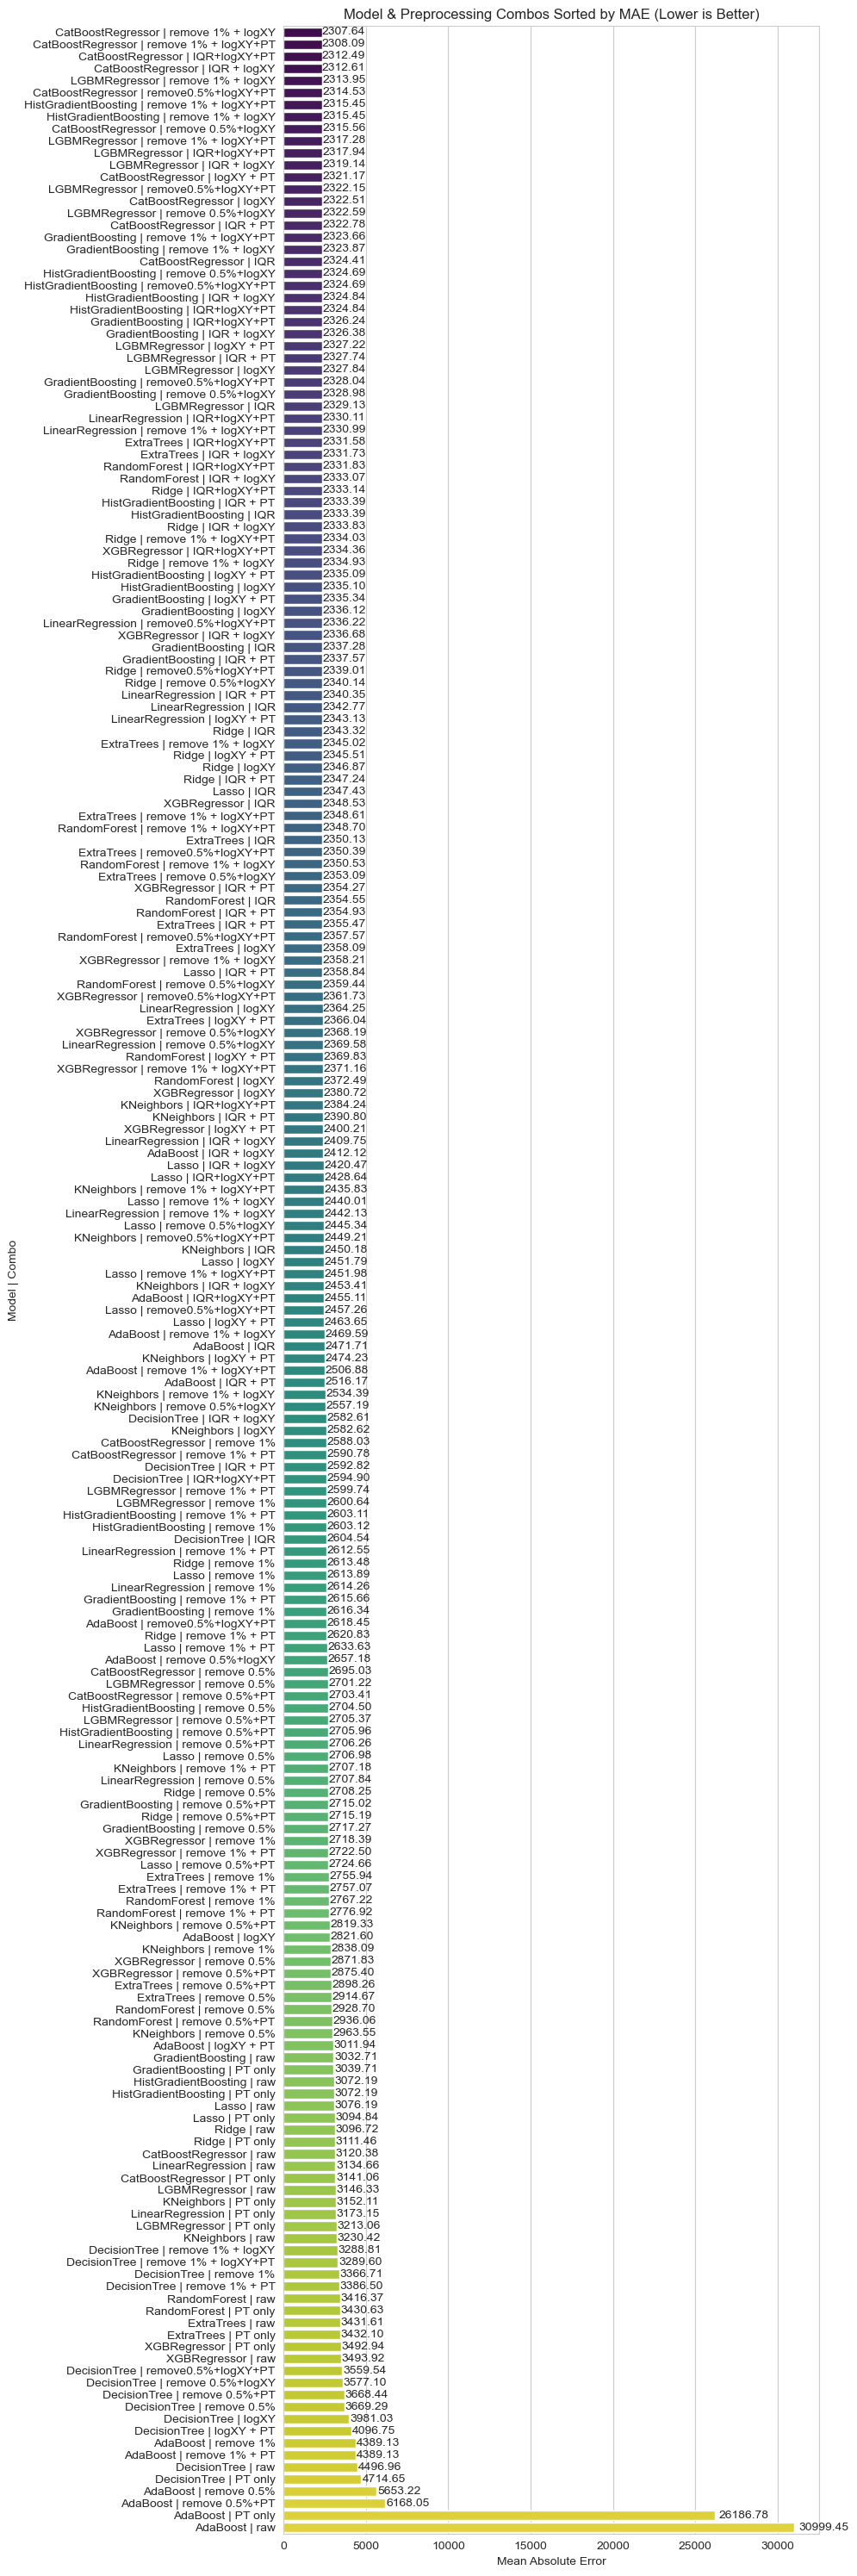

In [39]:
# 6) 시각화
plt.figure(figsize=(10, 30))
ax = sns.barplot(
    x='MAE',
    y=df['model'] + ' | ' + df['combo'],
    data=df,
    palette='viridis'
)
plt.title('Model & Preprocessing Combos Sorted by MAE (Lower is Better)')
plt.xlabel('Mean Absolute Error')
plt.ylabel('Model | Combo')

for p in ax.patches:
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.text(width + 0.01 * width, y, f"{width:.2f}", va='center')

plt.tight_layout()
plt.show()

상위 10개 결과를 보면 PT는 효과적이지 못함.

197	CatBoostRegressor	remove 1% + logXY	1.482069e+08	2310.604051  
181	LGBMRegressor	remove 1% + logXY	1.482740e+08	2310.955857  
205	CatBoostRegressor	IQR + logXY	1.507058e+08	2312.644684  
199	CatBoostRegressor	remove 1% + logXY+PT	1.482037e+08	2312.666845  
207	CatBoostRegressor	IQR+logXY+PT	1.507446e+08	2312.967935  
183	LGBMRegressor	remove 1% + logXY+PT	1.482051e+08	2314.831134  
189	LGBMRegressor	IQR + logXY	1.507363e+08	2318.363901  
191	LGBMRegressor	IQR+logXY+PT	1.507647e+08	2318.894286  
201	CatBoostRegressor	remove 0.5%+logXY	1.480473e+08	2318.997003  
187	LGBMRegressor	remove0.5%+logXY+PT	1.481278e+08	2319.078350  
185	LGBMRegressor	remove 0.5%+logXY	1.480498e+08	2319.392478  
151	HistGradientBoosting	remove 1% + logXY+PT	1.485917e+08	2320.001678  
149	HistGradientBoosting	remove 1% + logXY	1.485917e+08	2320.001678  
203	CatBoostRegressor	remove0.5%+logXY+PT	1.480934e+08	2321.903168  
204	CatBoostRegressor	IQR	1.497469e+08	2322.446722  
195	CatBoostRegressor	logXY + PT	1.477143e+08	2323.780359  
206	CatBoostRegressor	IQR + PT	1.497796e+08	2324.049536  
193	CatBoostRegressor	logXY	1.476645e+08	2324.221921  
133	GradientBoosting	remove 1% + logXY	1.487699e+08	2324.320708  
157	HistGradientBoosting	IQR + logXY	1.508897e+08	2324.432263  

---

### 전처리

In [40]:
# 전처리 함수: remove 1% + selective log1p on X
def preprocess(X, y, remove_pct=0.99):
    # 1) y 기준 이상치 제거
    thresh = np.percentile(y, remove_pct*100)
    mask = y <= thresh
    Xf = X.loc[mask].copy()
    yf = y.loc[mask].copy()
    # 2) y 로그 변환
    yf = np.log1p(yf)
    # 3) X selective log: skew>1 & non-negative
    skew_cols = Xf.columns[(Xf.skew().abs() > 1) & (Xf.min() >= 0)]
    Xf[skew_cols] = np.log1p(Xf[skew_cols])
    return Xf, yf, skew_cols

# train+valid 합치고 전처리
X_tv = pd.concat([X_train, X_valid], axis=0)
y_tv = pd.concat([y_train, y_valid], axis=0)
X_tv_proc, y_tv_proc, skew_cols = preprocess(X_tv, y_tv, remove_pct=0.99)

# test도 동일 전처리
X_test_proc = X_test.copy()
X_test_proc[skew_cols] = np.log1p(X_test_proc[skew_cols])

### 하이퍼파라미터 튜닝

In [41]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
import optuna

# PredefinedSplit 세팅 (전처리 후 인덱스로 train/valid 구분)
# 전처리로 남은 X_tv_proc.index가 원래 train인지 valid인지 판별
is_train = X_tv_proc.index.isin(X_train.index)  # True 면 train, False 면 valid
test_fold = np.where(is_train, -1, 0)
ps = PredefinedSplit(test_fold=test_fold)

# Optuna용 objective factory
def make_objective(model_name):
    def objective(trial):
        # 하이퍼파라미터
        if model_name == 'Cat':
            params = {
                'depth': trial.suggest_int('depth', 4, 10),
                'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
                'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 9, step=2),
                'iterations': trial.suggest_categorical('iterations', [200,500,800]),
                'border_count': trial.suggest_categorical('border_count', [32,64,128]),
                'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
                'random_state': 42, 'verbose': False
            }
            model = CatBoostRegressor(**params)
        elif model_name == 'LGBM':
            params = {
                'n_estimators': trial.suggest_categorical('n_estimators', [100,200,300]),
                'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),
                'num_leaves': trial.suggest_categorical('num_leaves', [31,63,127]),
                'max_depth': trial.suggest_categorical('max_depth', [-1,5,10,15]),
                'min_child_samples': trial.suggest_categorical('min_child_samples', [5,10,20]),
                'subsample': trial.suggest_categorical('subsample', [0.6,0.8,1.0]),
                'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.6,0.8,1.0]),
                'random_state': 42
            }
            model = LGBMRegressor(**params)
        elif model_name == 'HistGB':
            params = {
                'max_iter': trial.suggest_categorical('max_iter', [100,200,300]),
                'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
                'max_depth': trial.suggest_categorical('max_depth', [None,5,10]),
                'min_samples_leaf': trial.suggest_categorical('min_samples_leaf', [1,3,5]),
                'l2_regularization': trial.suggest_categorical('l2_regularization', [0.0,0.1,0.5])
            }
            model = HistGradientBoostingRegressor(**params, random_state=42)
        else:  # GB
            params = {
                'n_estimators': trial.suggest_categorical('n_estimators', [100,200,300]),
                'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
                'max_depth': trial.suggest_categorical('max_depth', [3,5,7]),
                'min_samples_split': trial.suggest_categorical('min_samples_split', [2,5,10]),
                'subsample': trial.suggest_categorical('subsample', [0.6,0.8,1.0]),
                'random_state': 42
            }
            model = GradientBoostingRegressor(**params)

        # PredefinedSplit CV
        preds = np.zeros(len(y_tv_proc))
        for train_idx, valid_idx in ps.split():
            X_tr, y_tr = X_tv_proc.iloc[train_idx], y_tv_proc.iloc[train_idx]
            X_va, y_va = X_tv_proc.iloc[valid_idx], y_tv_proc.iloc[valid_idx]

            if model_name == 'Cat':
                model.fit(X_tr, y_tr,
                        eval_set=(X_va, y_va),
                        use_best_model=True)
            elif model_name == 'LGBM':
                model.fit(X_tr, y_tr,
                        eval_set=[(X_va, y_va)])
            else:
                model.fit(X_tr, y_tr)

            preds[valid_idx] = model.predict(X_va)

        return mean_absolute_error(y_tv_proc, preds)
    return objective

# 모델별 Optuna 최적화 + 재학습
best_estimators = {}
studies = {} 

for name in tqdm(['Cat','LGBM','HistGB','GB'], desc="Optuna tuning"):
    study = optuna.create_study(
        direction='minimize',
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
    )
    study.optimize(make_objective(name), n_trials=50, show_progress_bar=True)
    studies[name] = study 
    print(f"{name} best params:", study.best_params)
    # 재학습
    if name == 'Cat':
        mdl = CatBoostRegressor(**study.best_params, random_state=42)
        mdl.fit(X_tv_proc, y_tv_proc)
    elif name == 'LGBM':
        mdl = LGBMRegressor(**study.best_params, random_state=42)
        mdl.fit(
            X_tv_proc, y_tv_proc,
            eval_set=(X_valid, y_valid)
        )
    elif name == 'HistGB':
        mdl = HistGradientBoostingRegressor(**study.best_params, random_state=42)
        mdl.fit(X_tv_proc, y_tv_proc)
    else:
        mdl = GradientBoostingRegressor(**study.best_params, random_state=42)
        mdl.fit(X_tv_proc, y_tv_proc)

    best_estimators[name] = mdl

# Test MAE/MSE 비교
results = []
for name, mdl in best_estimators.items():
    y_pred = np.expm1(mdl.predict(X_test_proc))
    results.append({
        'model': name,
        'test_MAE': mean_absolute_error(y_test, y_pred),
        'test_MSE': mean_squared_error(y_test, y_pred)
    })
    
df_test = pd.DataFrame(results).set_index('model').sort_values('test_MAE')

Optuna tuning:   0%|          | 0/4 [00:00<?, ?it/s][I 2025-05-06 04:04:57,046] A new study created in memory with name: no-name-97af198b-c180-4290-ba4d-40f45097912f


  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
Optuna tuning:   0%|          | 0/4 [00:00<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/t

[I 2025-05-06 04:04:57,616] Trial 0 finished with value: 5.731704236538604 and parameters: {'depth': 8, 'learning_rate': 0.012430691715176948, 'l2_leaf_reg': 5, 'iterations': 200, 'border_count': 128, 'bagging_temperature': 0.04743518309192718}. Best is trial 0 with value: 5.731704236538604.


Optuna tuning:   0%|          | 0/4 [00:00<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:04:57,941] Trial 1 finished with value: 5.737000422528556 and parameters: {'depth': 5, 'learning_rate': 0.005741207001560845, 'l2_leaf_reg': 9, 'iterations': 200, 'border_count': 64, 'bagging_temperature': 0.8300090310321873}. Best is trial 0 with value: 5.731704236538604.


Optuna tuning:   0%|          | 0/4 [00:01<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:04:58,246] Trial 2 finished with value: 5.728596604338235 and parameters: {'depth': 5, 'learning_rate': 0.07347952555325023, 'l2_leaf_reg': 5, 'iterations': 200, 'border_count': 128, 'bagging_temperature': 0.9147791007416858}. Best is trial 2 with value: 5.728596604338235.


Optuna tuning:   0%|          | 0/4 [00:01<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:04:58,801] Trial 3 finished with value: 5.731212989332256 and parameters: {'depth': 4, 'learning_rate': 0.010770830706164131, 'l2_leaf_reg': 9, 'iterations': 500, 'border_count': 64, 'bagging_temperature': 0.7019545579774347}. Best is trial 2 with value: 5.728596604338235.


Optuna tuning:   0%|          | 0/4 [00:02<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:04:59,106] Trial 4 finished with value: 5.72782546705467 and parameters: {'depth': 6, 'learning_rate': 0.09423518235949364, 'l2_leaf_reg': 9, 'iterations': 200, 'border_count': 64, 'bagging_temperature': 0.24467823952816337}. Best is trial 4 with value: 5.72782546705467.


Optuna tuning:   0%|          | 0/4 [00:04<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:05:01,285] Trial 5 finished with value: 5.727157844936564 and parameters: {'depth': 8, 'learning_rate': 0.025436429511434065, 'l2_leaf_reg': 5, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.3215391223248447}. Best is trial 5 with value: 5.727157844936564.


Optuna tuning:   0%|          | 0/4 [00:05<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:05:02,091] Trial 6 finished with value: 5.728021249027808 and parameters: {'depth': 4, 'learning_rate': 0.05066571788648418, 'l2_leaf_reg': 9, 'iterations': 800, 'border_count': 32, 'bagging_temperature': 0.4432239112745755}. Best is trial 5 with value: 5.727157844936564.


Optuna tuning:   0%|          | 0/4 [00:05<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:05:02,366] Trial 7 finished with value: 5.736682550352989 and parameters: {'depth': 5, 'learning_rate': 0.0060444050132126125, 'l2_leaf_reg': 3, 'iterations': 200, 'border_count': 64, 'bagging_temperature': 0.3592753995648482}. Best is trial 5 with value: 5.727157844936564.


Optuna tuning:   0%|          | 0/4 [00:06<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:05:03,211] Trial 8 finished with value: 5.727936924483504 and parameters: {'depth': 4, 'learning_rate': 0.08624871743239995, 'l2_leaf_reg': 3, 'iterations': 800, 'border_count': 32, 'bagging_temperature': 0.5691728201262535}. Best is trial 5 with value: 5.727157844936564.


Optuna tuning:   0%|          | 0/4 [00:07<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:05:04,611] Trial 9 finished with value: 5.72738732545591 and parameters: {'depth': 8, 'learning_rate': 0.02811725996964893, 'l2_leaf_reg': 3, 'iterations': 500, 'border_count': 128, 'bagging_temperature': 0.6800779880580765}. Best is trial 5 with value: 5.727157844936564.


Optuna tuning:   0%|          | 0/4 [00:12<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:05:09,679] Trial 10 finished with value: 5.726951847434453 and parameters: {'depth': 10, 'learning_rate': 0.02931883841169383, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.10636096695482533}. Best is trial 10 with value: 5.726951847434453.


Optuna tuning:   0%|          | 0/4 [00:17<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:05:14,593] Trial 11 finished with value: 5.727316261880517 and parameters: {'depth': 10, 'learning_rate': 0.03157266056586518, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.007757867470905122}. Best is trial 10 with value: 5.726951847434453.


Optuna tuning:   0%|          | 0/4 [00:22<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:05:19,296] Trial 12 finished with value: 5.727031730961359 and parameters: {'depth': 10, 'learning_rate': 0.016880599492455798, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.21662854634468895}. Best is trial 10 with value: 5.726951847434453.


Optuna tuning:   0%|          | 0/4 [00:26<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:05:23,892] Trial 13 finished with value: 5.72712474854436 and parameters: {'depth': 10, 'learning_rate': 0.01514970463346159, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.14413851307495634}. Best is trial 10 with value: 5.726951847434453.


Optuna tuning:   0%|          | 0/4 [00:29<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:05:26,945] Trial 14 finished with value: 5.727005075077402 and parameters: {'depth': 9, 'learning_rate': 0.04255957149221082, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.17075665738888404}. Best is trial 10 with value: 5.726951847434453.


Optuna tuning:   0%|          | 0/4 [00:32<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:05:29,986] Trial 15 finished with value: 5.727396209803678 and parameters: {'depth': 9, 'learning_rate': 0.044424726573751815, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.12793957990753305}. Best is trial 10 with value: 5.726951847434453.


Optuna tuning:   0%|          | 0/4 [00:35<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:05:32,077] Trial 16 finished with value: 5.72742232543831 and parameters: {'depth': 9, 'learning_rate': 0.04411852973013275, 'l2_leaf_reg': 7, 'iterations': 800, 'border_count': 32, 'bagging_temperature': 0.47976819407009097}. Best is trial 10 with value: 5.726951847434453.


Optuna tuning:   0%|          | 0/4 [00:36<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:05:33,945] Trial 17 finished with value: 5.727192104611494 and parameters: {'depth': 9, 'learning_rate': 0.056522488768067564, 'l2_leaf_reg': 3, 'iterations': 500, 'border_count': 128, 'bagging_temperature': 0.31397132172085285}. Best is trial 10 with value: 5.726951847434453.


Optuna tuning:   0%|          | 0/4 [00:38<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:05:35,523] Trial 18 finished with value: 5.72725745509049 and parameters: {'depth': 7, 'learning_rate': 0.03636753336541007, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.11369247418279578}. Best is trial 10 with value: 5.726951847434453.


Optuna tuning:   0%|          | 0/4 [00:39<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:05:36,828] Trial 19 finished with value: 5.727629449298195 and parameters: {'depth': 7, 'learning_rate': 0.021690945255741043, 'l2_leaf_reg': 7, 'iterations': 800, 'border_count': 32, 'bagging_temperature': 0.22682012004327892}. Best is trial 10 with value: 5.726951847434453.


Optuna tuning:   0%|          | 0/4 [00:41<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:05:38,673] Trial 20 finished with value: 5.727812110458067 and parameters: {'depth': 9, 'learning_rate': 0.020487367953654502, 'l2_leaf_reg': 3, 'iterations': 500, 'border_count': 128, 'bagging_temperature': 0.0003504680998418497}. Best is trial 10 with value: 5.726951847434453.


Optuna tuning:   0%|          | 0/4 [00:46<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:05:43,957] Trial 21 finished with value: 5.727040746990725 and parameters: {'depth': 10, 'learning_rate': 0.01829218256449597, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.1801218242318486}. Best is trial 10 with value: 5.726951847434453.


Optuna tuning:   0%|          | 0/4 [00:51<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:05:48,938] Trial 22 finished with value: 5.728217796639952 and parameters: {'depth': 10, 'learning_rate': 0.00851939534182799, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.258156652849641}. Best is trial 10 with value: 5.726951847434453.


Optuna tuning:   0%|          | 0/4 [00:56<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:05:53,920] Trial 23 finished with value: 5.727266499046541 and parameters: {'depth': 10, 'learning_rate': 0.03372884990464976, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.39509304113698784}. Best is trial 10 with value: 5.726951847434453.


Optuna tuning:   0%|          | 0/4 [00:59<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:05:56,992] Trial 24 finished with value: 5.727234401460135 and parameters: {'depth': 9, 'learning_rate': 0.06585767698365273, 'l2_leaf_reg': 3, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.08706229887730754}. Best is trial 10 with value: 5.726951847434453.


Optuna tuning:   0%|          | 0/4 [01:02<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:05:59,120] Trial 25 finished with value: 5.727611281513518 and parameters: {'depth': 8, 'learning_rate': 0.014820116087225527, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.5492212585349159}. Best is trial 10 with value: 5.726951847434453.


Optuna tuning:   0%|          | 0/4 [01:06<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:06:03,985] Trial 26 finished with value: 5.727209650855323 and parameters: {'depth': 10, 'learning_rate': 0.03880102090176285, 'l2_leaf_reg': 3, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.184613260100226}. Best is trial 10 with value: 5.726951847434453.


Optuna tuning:   0%|          | 0/4 [01:09<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:06:06,963] Trial 27 finished with value: 5.726935278518208 and parameters: {'depth': 9, 'learning_rate': 0.025792592747280286, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.2621830677336679}. Best is trial 27 with value: 5.726935278518208.


Optuna tuning:   0%|          | 0/4 [01:12<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:06:09,290] Trial 28 finished with value: 5.727150143699708 and parameters: {'depth': 9, 'learning_rate': 0.024736216436592674, 'l2_leaf_reg': 7, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0.2781468813713833}. Best is trial 27 with value: 5.726935278518208.


Optuna tuning:   0%|          | 0/4 [01:13<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:06:10,258] Trial 29 finished with value: 5.729177785665563 and parameters: {'depth': 8, 'learning_rate': 0.011856643370263617, 'l2_leaf_reg': 3, 'iterations': 500, 'border_count': 32, 'bagging_temperature': 0.042462428161602395}. Best is trial 27 with value: 5.726935278518208.


Optuna tuning:   0%|          | 0/4 [01:13<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:06:10,881] Trial 30 finished with value: 5.729218199910248 and parameters: {'depth': 8, 'learning_rate': 0.027713309033665503, 'l2_leaf_reg': 1, 'iterations': 200, 'border_count': 128, 'bagging_temperature': 0.07696603695184037}. Best is trial 27 with value: 5.726935278518208.


Optuna tuning:   0%|          | 0/4 [01:18<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:06:16,002] Trial 31 finished with value: 5.726898314282153 and parameters: {'depth': 10, 'learning_rate': 0.018415644217666904, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.19857680031767463}. Best is trial 31 with value: 5.726898314282153.


Optuna tuning:   0%|          | 0/4 [01:21<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:06:19,041] Trial 32 finished with value: 5.727082619773642 and parameters: {'depth': 9, 'learning_rate': 0.02071786894492624, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.1540041752550062}. Best is trial 31 with value: 5.726898314282153.


Optuna tuning:   0%|          | 0/4 [01:26<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:06:24,010] Trial 33 finished with value: 5.72697495433016 and parameters: {'depth': 10, 'learning_rate': 0.04389523291922627, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.39851865725796465}. Best is trial 31 with value: 5.726898314282153.


Optuna tuning:   0%|          | 0/4 [01:31<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:06:28,968] Trial 34 finished with value: 5.727055004303567 and parameters: {'depth': 10, 'learning_rate': 0.0307896488939677, 'l2_leaf_reg': 5, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.41290190276119043}. Best is trial 31 with value: 5.726898314282153.


Optuna tuning:   0%|          | 0/4 [01:32<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:06:29,912] Trial 35 finished with value: 5.732770704336502 and parameters: {'depth': 10, 'learning_rate': 0.008804225865954802, 'l2_leaf_reg': 3, 'iterations': 200, 'border_count': 64, 'bagging_temperature': 0.36222958253973575}. Best is trial 31 with value: 5.726898314282153.


Optuna tuning:   0%|          | 0/4 [01:37<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:06:34,971] Trial 36 finished with value: 5.726893781569198 and parameters: {'depth': 10, 'learning_rate': 0.02396691526758059, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.31758282713904396}. Best is trial 36 with value: 5.726893781569198.


Optuna tuning:   0%|          | 0/4 [01:38<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:06:35,328] Trial 37 finished with value: 5.732058736246506 and parameters: {'depth': 6, 'learning_rate': 0.01438461089881839, 'l2_leaf_reg': 5, 'iterations': 200, 'border_count': 128, 'bagging_temperature': 0.2929399430396205}. Best is trial 36 with value: 5.726893781569198.


Optuna tuning:   0%|          | 0/4 [01:40<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:06:37,622] Trial 38 finished with value: 5.726937295711504 and parameters: {'depth': 9, 'learning_rate': 0.01962176382547447, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0.3250187764393475}. Best is trial 36 with value: 5.726893781569198.


Optuna tuning:   0%|          | 0/4 [01:41<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:06:38,822] Trial 39 finished with value: 5.728279066708893 and parameters: {'depth': 8, 'learning_rate': 0.018069768793007993, 'l2_leaf_reg': 3, 'iterations': 500, 'border_count': 64, 'bagging_temperature': 0.9125594844083137}. Best is trial 36 with value: 5.726893781569198.


Optuna tuning:   0%|          | 0/4 [01:42<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:06:40,018] Trial 40 finished with value: 5.729031567783544 and parameters: {'depth': 6, 'learning_rate': 0.01008291084853279, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0.4670049933065657}. Best is trial 36 with value: 5.726893781569198.


Optuna tuning:   0%|          | 0/4 [01:45<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:06:42,441] Trial 41 finished with value: 5.727230440881625 and parameters: {'depth': 9, 'learning_rate': 0.024500818742359605, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0.3243453729588668}. Best is trial 36 with value: 5.726893781569198.


Optuna tuning:   0%|          | 0/4 [01:49<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:06:46,142] Trial 42 finished with value: 5.727205448026802 and parameters: {'depth': 10, 'learning_rate': 0.023509735096149918, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0.22982806262355024}. Best is trial 36 with value: 5.726893781569198.


Optuna tuning:   0%|          | 0/4 [01:51<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:06:48,541] Trial 43 finished with value: 5.7270675391151 and parameters: {'depth': 9, 'learning_rate': 0.029186421633786073, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 64, 'bagging_temperature': 0.7023943885586398}. Best is trial 36 with value: 5.726893781569198.


Optuna tuning:   0%|          | 0/4 [01:56<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:06:53,506] Trial 44 finished with value: 5.727581865169856 and parameters: {'depth': 10, 'learning_rate': 0.013302277623806263, 'l2_leaf_reg': 3, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.5334995637187154}. Best is trial 36 with value: 5.726893781569198.


Optuna tuning:   0%|          | 0/4 [01:59<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:06:56,536] Trial 45 finished with value: 5.7272815112231115 and parameters: {'depth': 10, 'learning_rate': 0.017273020481431124, 'l2_leaf_reg': 1, 'iterations': 800, 'border_count': 32, 'bagging_temperature': 0.34329477206687986}. Best is trial 36 with value: 5.726893781569198.


Optuna tuning:   0%|          | 0/4 [02:00<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:06:57,125] Trial 46 finished with value: 5.729670321954583 and parameters: {'depth': 9, 'learning_rate': 0.019712705277886704, 'l2_leaf_reg': 1, 'iterations': 200, 'border_count': 64, 'bagging_temperature': 0.2613542293611708}. Best is trial 36 with value: 5.726893781569198.


Optuna tuning:   0%|          | 0/4 [02:05<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:07:02,084] Trial 47 finished with value: 5.726841520690503 and parameters: {'depth': 10, 'learning_rate': 0.026349765674899047, 'l2_leaf_reg': 3, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.6160928298894557}. Best is trial 47 with value: 5.726841520690503.


Optuna tuning:   0%|          | 0/4 [02:08<?, ?it/s]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),


[I 2025-05-06 04:07:05,106] Trial 48 finished with value: 5.727066197736933 and parameters: {'depth': 9, 'learning_rate': 0.026772603928789523, 'l2_leaf_reg': 3, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.5890255589602296}. Best is trial 47 with value: 5.726841520690503.


Optuna tuning:   0%|          | 0/4 [02:10<?, ?it/s]

[I 2025-05-06 04:07:07,173] Trial 49 finished with value: 5.727530194318714 and parameters: {'depth': 8, 'learning_rate': 0.01587815644572134, 'l2_leaf_reg': 3, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.6907283458014499}. Best is trial 47 with value: 5.726841520690503.
Cat best params: {'depth': 10, 'learning_rate': 0.026349765674899047, 'l2_leaf_reg': 3, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.6160928298894557}
0:	learn: 0.8597147	total: 8.12ms	remaining: 6.49s
1:	learn: 0.8568249	total: 15.9ms	remaining: 6.35s
2:	learn: 0.8543829	total: 24.1ms	remaining: 6.39s
3:	learn: 0.8518136	total: 32ms	remaining: 6.36s
4:	learn: 0.8493139	total: 38.1ms	remaining: 6.06s
5:	learn: 0.8470308	total: 44.1ms	remaining: 5.83s
6:	learn: 0.8449287	total: 50.2ms	remaining: 5.69s
7:	learn: 0.8427979	total: 57.5ms	remaining: 5.69s
8:	learn: 0.8407414	total: 69ms	remaining: 6.06s
9:	learn: 0.8388733	total: 75.8ms	remaining: 5.99s
10:	learn: 0.8368282	total: 82

Optuna tuning:  25%|██▌       | 1/4 [02:15<06:46, 135.48s/it][I 2025-05-06 04:07:12,522] A new study created in memory with name: no-name-1786e152-c468-40ba-90e5-a26b6a904780


  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:16<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:07:13,092] Trial 0 finished with value: 5.733334662042071 and parameters: {'n_estimators': 100, 'learning_rate': 0.01258222472156376, 'num_leaves': 63, 'max_depth': -1, 'min_child_samples': 5, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 0 with value: 5.733334662042071.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:16<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:07:13,761] Trial 1 finished with value: 5.730509523063824 and parameters: {'n_estimators': 200, 'learning_rate': 0.012479041221696775, 'num_leaves': 31, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 0.8, 'colsample_bytree': 1.0}. Best is trial 1 with value: 5.730509523063824.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:19<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:07:16,510] Trial 2 finished with value: 5.7317240287242575 and parameters: {'n_estimators': 300, 'learning_rate': 0.005105638755166005, 'num_leaves': 127, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.8, 'colsample_bytree': 1.0}. Best is trial 1 with value: 5.730509523063824.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:22<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:07:19,176] Trial 3 finished with value: 5.727756116126877 and parameters: {'n_estimators': 300, 'learning_rate': 0.0312524932731659, 'num_leaves': 127, 'max_depth': 15, 'min_child_samples': 5, 'subsample': 1.0, 'colsample_bytree': 0.8}. Best is trial 3 with value: 5.727756116126877.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:24<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:07:21,644] Trial 4 finished with value: 5.727302129667836 and parameters: {'n_estimators': 300, 'learning_rate': 0.024246751403007288, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:25<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:07:22,687] Trial 5 finished with value: 5.732821222978214 and parameters: {'n_estimators': 300, 'learning_rate': 0.0051986288556734265, 'num_leaves': 31, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 1.0, 'colsample_bytree': 0.8}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:27<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:07:24,176] Trial 6 finished with value: 5.727615783458038 and parameters: {'n_estimators': 300, 'learning_rate': 0.03355001910061971, 'num_leaves': 63, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:28<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:07:25,316] Trial 7 finished with value: 5.728241576001819 and parameters: {'n_estimators': 200, 'learning_rate': 0.03264711273648664, 'num_leaves': 63, 'max_depth': 15, 'min_child_samples': 5, 'subsample': 0.8, 'colsample_bytree': 1.0}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

Optuna tuning:  25%|██▌       | 1/4 [02:29<06:46, 135.48s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),
Optuna tuning:  25%|██▌       | 1/4 [02:30<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:07:27,432] Trial 9 finished with value: 5.728759376755027 and parameters: {'n_estimators': 100, 'learning_rate': 0.030957168700949462, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

Optuna tuning:  25%|██▌       | 1/4 [02:31<06:46, 135.48s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2025-05-06 04:07:28,058] Trial 10 finished with value: 5.7293869077118345 and parameters: {'n_estimators': 200, 'learning_rate': 0.019869078776501962, 'num_leaves': 127, 'max_depth': 5, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace

/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),
Optuna tuning:  25%|██▌       | 1/4 [02:33<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:07:30,106] Trial 11 finished with value: 5.72765656619186 and parameters: {'n_estimators': 300, 'learning_rate': 0.019976400555561925, 'num_leaves': 63, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:36<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:07:33,434] Trial 12 finished with value: 5.7274176403795085 and parameters: {'n_estimators': 300, 'learning_rate': 0.044912750030126444, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:39<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:07:36,896] Trial 13 finished with value: 5.727765613459225 and parameters: {'n_estimators': 300, 'learning_rate': 0.04352778946494844, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:43<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:07:40,149] Trial 14 finished with value: 5.7277449656810555 and parameters: {'n_estimators': 300, 'learning_rate': 0.047881061885389355, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:44<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:07:41,354] Trial 15 finished with value: 5.729664404332176 and parameters: {'n_estimators': 100, 'learning_rate': 0.02268718182907055, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:48<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:07:45,079] Trial 16 finished with value: 5.729353488386024 and parameters: {'n_estimators': 300, 'learning_rate': 0.007688187820819805, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:49<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:07:46,188] Trial 17 finished with value: 5.728108850925323 and parameters: {'n_estimators': 300, 'learning_rate': 0.023803886444875258, 'num_leaves': 31, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

Optuna tuning:  25%|██▌       | 1/4 [02:49<06:46, 135.48s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),
Optuna tuning:  25%|██▌       | 1/4 [02:52<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:07:49,193] Trial 19 finished with value: 5.729566145638117 and parameters: {'n_estimators': 200, 'learning_rate': 0.011458295308869975, 'num_leaves': 127, 'max_depth': 15, 'min_child_samples': 20, 'subsample': 0.6, 'colsample_bytree': 1.0}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:53<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:07:50,230] Trial 20 finished with value: 5.728063736603878 and parameters: {'n_estimators': 300, 'learning_rate': 0.02624595917048557, 'num_leaves': 31, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:54<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:07:51,935] Trial 21 finished with value: 5.727918899772843 and parameters: {'n_estimators': 300, 'learning_rate': 0.03870591312840944, 'num_leaves': 63, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:56<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:07:53,922] Trial 22 finished with value: 5.728107024914566 and parameters: {'n_estimators': 300, 'learning_rate': 0.015504402601235026, 'num_leaves': 63, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [02:58<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:07:55,961] Trial 23 finished with value: 5.727635257074978 and parameters: {'n_estimators': 300, 'learning_rate': 0.02701444040846813, 'num_leaves': 63, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [03:02<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:07:59,479] Trial 24 finished with value: 5.727590093089271 and parameters: {'n_estimators': 300, 'learning_rate': 0.03917976583164395, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [03:05<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:08:03,016] Trial 25 finished with value: 5.727546358384787 and parameters: {'n_estimators': 300, 'learning_rate': 0.04079046621968062, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [03:09<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:08:06,783] Trial 26 finished with value: 5.727492380015304 and parameters: {'n_estimators': 300, 'learning_rate': 0.01709632424754627, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [03:13<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:08:10,598] Trial 27 finished with value: 5.727440193991574 and parameters: {'n_estimators': 300, 'learning_rate': 0.01587802676366632, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [03:14<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:08:11,995] Trial 28 finished with value: 5.734449837104027 and parameters: {'n_estimators': 100, 'learning_rate': 0.00935445597220239, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 0.8, 'colsample_bytree': 1.0}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [03:17<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:08:14,639] Trial 29 finished with value: 5.728436396933444 and parameters: {'n_estimators': 200, 'learning_rate': 0.01536188056381856, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 1.0, 'colsample_bytree': 0.8}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [03:18<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:08:16,006] Trial 30 finished with value: 5.729946405565152 and parameters: {'n_estimators': 100, 'learning_rate': 0.020023970928840833, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [03:22<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:08:19,669] Trial 31 finished with value: 5.72769907886895 and parameters: {'n_estimators': 300, 'learning_rate': 0.017049826095202426, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [03:27<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:08:24,127] Trial 32 finished with value: 5.727832240089193 and parameters: {'n_estimators': 300, 'learning_rate': 0.01345749496230915, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [03:31<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:08:28,156] Trial 33 finished with value: 5.7281862531327015 and parameters: {'n_estimators': 300, 'learning_rate': 0.011451625471555682, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [03:32<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:08:29,562] Trial 34 finished with value: 5.728781812787122 and parameters: {'n_estimators': 300, 'learning_rate': 0.014219421941108082, 'num_leaves': 31, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 0.6, 'colsample_bytree': 1.0}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [03:36<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:08:33,806] Trial 35 finished with value: 5.727711207934681 and parameters: {'n_estimators': 300, 'learning_rate': 0.017748165400901718, 'num_leaves': 127, 'max_depth': 15, 'min_child_samples': 10, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [03:40<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:08:37,602] Trial 36 finished with value: 5.72840497202122 and parameters: {'n_estimators': 300, 'learning_rate': 0.010253101378445536, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

Optuna tuning:  25%|██▌       | 1/4 [03:41<06:46, 135.48s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),
Optuna tuning:  25%|██▌       | 1/4 [03:44<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:08:41,651] Trial 38 finished with value: 5.729642206350216 and parameters: {'n_estimators': 300, 'learning_rate': 0.007645242792822965, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 0.8, 'colsample_bytree': 1.0}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [03:48<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:08:45,164] Trial 39 finished with value: 5.727503019829984 and parameters: {'n_estimators': 300, 'learning_rate': 0.017380523989965244, 'num_leaves': 127, 'max_depth': 15, 'min_child_samples': 20, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [03:51<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:08:48,557] Trial 40 finished with value: 5.727322599190158 and parameters: {'n_estimators': 300, 'learning_rate': 0.023325239709210407, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [03:54<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:08:51,994] Trial 41 finished with value: 5.727591667624429 and parameters: {'n_estimators': 300, 'learning_rate': 0.022018476295565335, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [03:58<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:08:55,746] Trial 42 finished with value: 5.7273108122244345 and parameters: {'n_estimators': 300, 'learning_rate': 0.03196596740601167, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [04:02<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:08:59,081] Trial 43 finished with value: 5.727425322716255 and parameters: {'n_estimators': 300, 'learning_rate': 0.030167651205943693, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [04:05<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:09:02,636] Trial 44 finished with value: 5.727379025629901 and parameters: {'n_estimators': 300, 'learning_rate': 0.030936946229052763, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

Optuna tuning:  25%|██▌       | 1/4 [04:06<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:09:03,459] Trial 45 finished with value: 5.727786187616303 and parameters: {'n_estimators': 300, 'learning_rate': 0.03420617030274762, 'num_leaves': 127, 'max_depth': 5, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.8}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [04:08<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:09:05,848] Trial 46 finished with value: 5.727487508002136 and parameters: {'n_estimators': 200, 'learning_rate': 0.029538685296415776, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [04:12<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:09:09,538] Trial 47 finished with value: 5.727766464387286 and parameters: {'n_estimators': 300, 'learning_rate': 0.03457746674300736, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [04:12<06:46, 135.48s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),


[I 2025-05-06 04:09:09,959] Trial 48 finished with value: 5.728639295160877 and parameters: {'n_estimators': 100, 'learning_rate': 0.04498047363073388, 'num_leaves': 31, 'max_depth': 15, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 4 with value: 5.727302129667836.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 23544, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.443191


Optuna tuning:  25%|██▌       | 1/4 [04:16<06:46, 135.48s/it]

[I 2025-05-06 04:09:13,318] Trial 49 finished with value: 5.7271546899194705 and parameters: {'n_estimators': 300, 'learning_rate': 0.02563262643315707, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 49 with value: 5.7271546899194705.
LGBM best params: {'n_estimators': 300, 'learning_rate': 0.02563262643315707, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.6}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8478
[LightGBM] [Info] Number of data points in the train set: 31400, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.440042


Optuna tuning:  50%|█████     | 2/4 [04:19<04:17, 128.97s/it][I 2025-05-06 04:09:16,938] A new study created in memory with name: no-name-6db496e8-68f1-499e-ac7e-59697feaf713


  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
Optuna tuning:  50%|█████     | 2/4 [04:21<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:09:18,111] Trial 0 finished with value: 5.728578801322771 and parameters: {'max_iter': 200, 'learning_rate': 0.04613324775328663, 'max_depth': None, 'min_samples_leaf': 1, 'l2_regularization': 0.5}. Best is trial 0 with value: 5.728578801322771.


Optuna tuning:  50%|█████     | 2/4 [04:21<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:09:18,769] Trial 1 finished with value: 5.7294986473548475 and parameters: {'max_iter': 100, 'learning_rate': 0.04053292340997909, 'max_depth': 5, 'min_samples_leaf': 3, 'l2_regularization': 0.0}. Best is trial 0 with value: 5.728578801322771.


Optuna tuning:  50%|█████     | 2/4 [04:23<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:09:20,391] Trial 2 finished with value: 5.728261655654797 and parameters: {'max_iter': 200, 'learning_rate': 0.03750435388228743, 'max_depth': None, 'min_samples_leaf': 1, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [04:26<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:09:23,053] Trial 3 finished with value: 5.728405506145462 and parameters: {'max_iter': 300, 'learning_rate': 0.01964127841534067, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [04:26<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:09:23,694] Trial 4 finished with value: 5.730395735162564 and parameters: {'max_iter': 100, 'learning_rate': 0.03097997905662402, 'max_depth': 5, 'min_samples_leaf': 3, 'l2_regularization': 0.0}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [04:27<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:09:24,888] Trial 5 finished with value: 5.728494418777175 and parameters: {'max_iter': 200, 'learning_rate': 0.04168756502186137, 'max_depth': None, 'min_samples_leaf': 3, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [04:28<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:09:25,788] Trial 6 finished with value: 5.728939793147314 and parameters: {'max_iter': 300, 'learning_rate': 0.02917129056761798, 'max_depth': 5, 'min_samples_leaf': 3, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [04:29<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:09:26,640] Trial 7 finished with value: 5.733560725499227 and parameters: {'max_iter': 100, 'learning_rate': 0.013879159089174033, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [04:31<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:09:28,474] Trial 8 finished with value: 5.728487442428771 and parameters: {'max_iter': 300, 'learning_rate': 0.03512032174671904, 'max_depth': None, 'min_samples_leaf': 3, 'l2_regularization': 0.5}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [04:33<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:09:30,183] Trial 9 finished with value: 5.728620678603146 and parameters: {'max_iter': 200, 'learning_rate': 0.040337881472457, 'max_depth': None, 'min_samples_leaf': 3, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [04:35<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:09:32,207] Trial 10 finished with value: 5.728957598325187 and parameters: {'max_iter': 200, 'learning_rate': 0.02177419345663532, 'max_depth': None, 'min_samples_leaf': 1, 'l2_regularization': 0.0}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [04:37<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:09:34,600] Trial 11 finished with value: 5.728631632015636 and parameters: {'max_iter': 300, 'learning_rate': 0.01957238131031448, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [04:40<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:09:37,352] Trial 12 finished with value: 5.728810632380267 and parameters: {'max_iter': 300, 'learning_rate': 0.015630532405533495, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [04:42<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:09:39,357] Trial 13 finished with value: 5.7309718048233105 and parameters: {'max_iter': 200, 'learning_rate': 0.011189299223129567, 'max_depth': 10, 'min_samples_leaf': 1, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [04:44<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:09:41,388] Trial 14 finished with value: 5.7286925776294195 and parameters: {'max_iter': 300, 'learning_rate': 0.026285629044754996, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [04:46<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:09:43,352] Trial 15 finished with value: 5.7294998394508925 and parameters: {'max_iter': 200, 'learning_rate': 0.016726922566111458, 'max_depth': None, 'min_samples_leaf': 1, 'l2_regularization': 0.5}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [04:48<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:09:45,274] Trial 16 finished with value: 5.728486898720785 and parameters: {'max_iter': 300, 'learning_rate': 0.02565511393485875, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [04:50<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:09:47,372] Trial 17 finished with value: 5.729058591019624 and parameters: {'max_iter': 200, 'learning_rate': 0.019656475113254093, 'max_depth': None, 'min_samples_leaf': 1, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [04:53<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:09:50,104] Trial 18 finished with value: 5.7294294823435035 and parameters: {'max_iter': 300, 'learning_rate': 0.011743514618852558, 'max_depth': 10, 'min_samples_leaf': 1, 'l2_regularization': 0.0}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [04:53<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:09:50,699] Trial 19 finished with value: 5.730043450908982 and parameters: {'max_iter': 100, 'learning_rate': 0.03405011852543486, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.5}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [04:55<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:09:52,365] Trial 20 finished with value: 5.728713822296141 and parameters: {'max_iter': 300, 'learning_rate': 0.025026628892297394, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [04:57<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:09:54,378] Trial 21 finished with value: 5.728454298668313 and parameters: {'max_iter': 300, 'learning_rate': 0.025293506243812863, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [04:59<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:09:56,625] Trial 22 finished with value: 5.72843157246855 and parameters: {'max_iter': 300, 'learning_rate': 0.02090247415049559, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [05:01<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:09:58,967] Trial 23 finished with value: 5.728675943677249 and parameters: {'max_iter': 300, 'learning_rate': 0.018075341366032123, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [05:04<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:10:01,510] Trial 24 finished with value: 5.728914475894532 and parameters: {'max_iter': 300, 'learning_rate': 0.014424487384338604, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [05:06<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:10:03,476] Trial 25 finished with value: 5.728900678073998 and parameters: {'max_iter': 200, 'learning_rate': 0.021979745198714342, 'max_depth': None, 'min_samples_leaf': 1, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [05:08<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:10:05,937] Trial 26 finished with value: 5.7292197775516005 and parameters: {'max_iter': 300, 'learning_rate': 0.013045120420895034, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [05:11<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:10:08,309] Trial 27 finished with value: 5.728690090086795 and parameters: {'max_iter': 300, 'learning_rate': 0.017678350526537948, 'max_depth': 10, 'min_samples_leaf': 1, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [05:12<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:10:09,084] Trial 28 finished with value: 5.731989676921563 and parameters: {'max_iter': 100, 'learning_rate': 0.02096857336367413, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.0}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [05:14<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:10:11,209] Trial 29 finished with value: 5.731485355925315 and parameters: {'max_iter': 200, 'learning_rate': 0.01023654067827251, 'max_depth': None, 'min_samples_leaf': 1, 'l2_regularization': 0.5}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [05:16<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:10:13,063] Trial 30 finished with value: 5.728516124750052 and parameters: {'max_iter': 200, 'learning_rate': 0.028791999512948703, 'max_depth': None, 'min_samples_leaf': 5, 'l2_regularization': 0.5}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [05:17<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:10:14,218] Trial 31 finished with value: 5.728571182737629 and parameters: {'max_iter': 300, 'learning_rate': 0.04634668930044322, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [05:18<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:10:15,952] Trial 32 finished with value: 5.728773803600474 and parameters: {'max_iter': 300, 'learning_rate': 0.024351186003571272, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [05:20<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:10:17,893] Trial 33 finished with value: 5.728748523697585 and parameters: {'max_iter': 300, 'learning_rate': 0.023036825396210964, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [05:22<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:10:19,794] Trial 34 finished with value: 5.728471193056201 and parameters: {'max_iter': 300, 'learning_rate': 0.03563559151187564, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [05:23<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:10:20,440] Trial 35 finished with value: 5.729205876876789 and parameters: {'max_iter': 100, 'learning_rate': 0.04939989452520805, 'max_depth': 5, 'min_samples_leaf': 1, 'l2_regularization': 0.0}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [05:25<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:10:22,817] Trial 36 finished with value: 5.728483708473722 and parameters: {'max_iter': 300, 'learning_rate': 0.031581120900911905, 'max_depth': 10, 'min_samples_leaf': 3, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [05:26<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:10:23,501] Trial 37 finished with value: 5.730628920236577 and parameters: {'max_iter': 100, 'learning_rate': 0.028290332219834388, 'max_depth': 5, 'min_samples_leaf': 5, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [05:27<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:10:24,980] Trial 38 finished with value: 5.728569312623374 and parameters: {'max_iter': 300, 'learning_rate': 0.03976848238257533, 'max_depth': None, 'min_samples_leaf': 3, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [05:29<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:10:26,872] Trial 39 finished with value: 5.729178960604009 and parameters: {'max_iter': 200, 'learning_rate': 0.01951297924786742, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.0}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [05:31<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:10:28,756] Trial 40 finished with value: 5.728551017391074 and parameters: {'max_iter': 300, 'learning_rate': 0.031109165654665063, 'max_depth': None, 'min_samples_leaf': 3, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [05:33<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:10:30,604] Trial 41 finished with value: 5.728468954080181 and parameters: {'max_iter': 300, 'learning_rate': 0.03653625599053597, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [05:35<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:10:32,300] Trial 42 finished with value: 5.728450364721813 and parameters: {'max_iter': 300, 'learning_rate': 0.035985116830274985, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [05:36<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:10:33,900] Trial 43 finished with value: 5.728555737316172 and parameters: {'max_iter': 300, 'learning_rate': 0.03875000005968905, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [05:38<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:10:35,256] Trial 44 finished with value: 5.728501436677866 and parameters: {'max_iter': 300, 'learning_rate': 0.04460087464772829, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [05:40<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:10:37,356] Trial 45 finished with value: 5.728695017896603 and parameters: {'max_iter': 200, 'learning_rate': 0.027501655764283112, 'max_depth': 10, 'min_samples_leaf': 5, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [05:42<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:10:39,495] Trial 46 finished with value: 5.72826279084917 and parameters: {'max_iter': 300, 'learning_rate': 0.033247981156362336, 'max_depth': 10, 'min_samples_leaf': 1, 'l2_regularization': 0.1}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [05:44<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:10:41,354] Trial 47 finished with value: 5.728271159749435 and parameters: {'max_iter': 300, 'learning_rate': 0.032820719674039225, 'max_depth': None, 'min_samples_leaf': 1, 'l2_regularization': 0.5}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [05:46<04:17, 128.97s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:10:43,109] Trial 48 finished with value: 5.72829907406542 and parameters: {'max_iter': 200, 'learning_rate': 0.03295252078838196, 'max_depth': None, 'min_samples_leaf': 1, 'l2_regularization': 0.5}. Best is trial 2 with value: 5.728261655654797.


Optuna tuning:  50%|█████     | 2/4 [05:47<04:17, 128.97s/it]

[I 2025-05-06 04:10:44,771] Trial 49 finished with value: 5.728280844926876 and parameters: {'max_iter': 200, 'learning_rate': 0.03296470822199173, 'max_depth': None, 'min_samples_leaf': 1, 'l2_regularization': 0.5}. Best is trial 2 with value: 5.728261655654797.
HistGB best params: {'max_iter': 200, 'learning_rate': 0.03750435388228743, 'max_depth': None, 'min_samples_leaf': 1, 'l2_regularization': 0.1}


Optuna tuning:  75%|███████▌  | 3/4 [05:49<01:50, 110.93s/it][I 2025-05-06 04:10:46,405] A new study created in memory with name: no-name-78fb5624-05f3-4a52-98a2-a6ca4151a533


  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
Optuna tuning:  75%|███████▌  | 3/4 [06:54<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:11:51,487] Trial 0 finished with value: 5.728932527127634 and parameters: {'n_estimators': 300, 'learning_rate': 0.016968744892707728, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 1.0}. Best is trial 0 with value: 5.728932527127634.


Optuna tuning:  75%|███████▌  | 3/4 [07:26<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:12:23,251] Trial 1 finished with value: 5.728913582624702 and parameters: {'n_estimators': 300, 'learning_rate': 0.03854915643006613, 'max_depth': 3, 'min_samples_split': 10, 'subsample': 0.8}. Best is trial 1 with value: 5.728913582624702.


Optuna tuning:  75%|███████▌  | 3/4 [07:39<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:12:36,209] Trial 2 finished with value: 5.729161206652158 and parameters: {'n_estimators': 100, 'learning_rate': 0.049057942696873254, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 1 with value: 5.728913582624702.


Optuna tuning:  75%|███████▌  | 3/4 [08:26<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:13:23,821] Trial 3 finished with value: 5.727868686298814 and parameters: {'n_estimators': 200, 'learning_rate': 0.038121993058776345, 'max_depth': 7, 'min_samples_split': 2, 'subsample': 0.8}. Best is trial 3 with value: 5.727868686298814.


Optuna tuning:  75%|███████▌  | 3/4 [08:37<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:13:34,378] Trial 4 finished with value: 5.738214826797406 and parameters: {'n_estimators': 100, 'learning_rate': 0.010490666998755097, 'max_depth': 3, 'min_samples_split': 10, 'subsample': 0.8}. Best is trial 3 with value: 5.727868686298814.


Optuna tuning:  75%|███████▌  | 3/4 [09:09<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:14:06,219] Trial 5 finished with value: 5.729096275114496 and parameters: {'n_estimators': 300, 'learning_rate': 0.034010527690460195, 'max_depth': 3, 'min_samples_split': 10, 'subsample': 0.8}. Best is trial 3 with value: 5.727868686298814.


Optuna tuning:  75%|███████▌  | 3/4 [09:32<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:14:29,492] Trial 6 finished with value: 5.728743864465345 and parameters: {'n_estimators': 100, 'learning_rate': 0.04399143309311502, 'max_depth': 7, 'min_samples_split': 10, 'subsample': 0.8}. Best is trial 3 with value: 5.727868686298814.


Optuna tuning:  75%|███████▌  | 3/4 [11:00<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:15:57,357] Trial 7 finished with value: 5.728945224160401 and parameters: {'n_estimators': 300, 'learning_rate': 0.017917039575947404, 'max_depth': 7, 'min_samples_split': 2, 'subsample': 1.0}. Best is trial 3 with value: 5.727868686298814.


Optuna tuning:  75%|███████▌  | 3/4 [11:23<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:16:20,564] Trial 8 finished with value: 5.732477169585641 and parameters: {'n_estimators': 100, 'learning_rate': 0.014023864383262693, 'max_depth': 7, 'min_samples_split': 10, 'subsample': 0.8}. Best is trial 3 with value: 5.727868686298814.


Optuna tuning:  75%|███████▌  | 3/4 [12:21<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:17:18,475] Trial 9 finished with value: 5.728494132456042 and parameters: {'n_estimators': 200, 'learning_rate': 0.03953430865290123, 'max_depth': 7, 'min_samples_split': 2, 'subsample': 1.0}. Best is trial 3 with value: 5.727868686298814.


Optuna tuning:  75%|███████▌  | 3/4 [12:56<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:17:53,299] Trial 10 finished with value: 5.728406378659558 and parameters: {'n_estimators': 200, 'learning_rate': 0.027183410853890606, 'max_depth': 7, 'min_samples_split': 5, 'subsample': 0.6}. Best is trial 3 with value: 5.727868686298814.


Optuna tuning:  75%|███████▌  | 3/4 [13:30<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:18:27,418] Trial 11 finished with value: 5.728021253959765 and parameters: {'n_estimators': 200, 'learning_rate': 0.027214633524719117, 'max_depth': 7, 'min_samples_split': 5, 'subsample': 0.6}. Best is trial 3 with value: 5.727868686298814.


Optuna tuning:  75%|███████▌  | 3/4 [14:04<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:19:01,503] Trial 12 finished with value: 5.728275982227538 and parameters: {'n_estimators': 200, 'learning_rate': 0.02706933059837073, 'max_depth': 7, 'min_samples_split': 5, 'subsample': 0.6}. Best is trial 3 with value: 5.727868686298814.


Optuna tuning:  75%|███████▌  | 3/4 [14:39<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:19:36,634] Trial 13 finished with value: 5.728308796966706 and parameters: {'n_estimators': 200, 'learning_rate': 0.02759080094718641, 'max_depth': 7, 'min_samples_split': 2, 'subsample': 0.6}. Best is trial 3 with value: 5.727868686298814.


Optuna tuning:  75%|███████▌  | 3/4 [15:14<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:20:11,584] Trial 14 finished with value: 5.72853885418751 and parameters: {'n_estimators': 200, 'learning_rate': 0.022086194526793643, 'max_depth': 7, 'min_samples_split': 5, 'subsample': 0.6}. Best is trial 3 with value: 5.727868686298814.


Optuna tuning:  75%|███████▌  | 3/4 [15:48<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:20:45,755] Trial 15 finished with value: 5.728586832641918 and parameters: {'n_estimators': 200, 'learning_rate': 0.03156206272761864, 'max_depth': 5, 'min_samples_split': 5, 'subsample': 0.8}. Best is trial 3 with value: 5.727868686298814.


Optuna tuning:  75%|███████▌  | 3/4 [16:23<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:21:20,547] Trial 16 finished with value: 5.728431831386185 and parameters: {'n_estimators': 200, 'learning_rate': 0.02180642400519904, 'max_depth': 7, 'min_samples_split': 2, 'subsample': 0.6}. Best is trial 3 with value: 5.727868686298814.


Optuna tuning:  75%|███████▌  | 3/4 [16:58<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:21:55,790] Trial 17 finished with value: 5.7276717031907065 and parameters: {'n_estimators': 200, 'learning_rate': 0.03585513248928225, 'max_depth': 7, 'min_samples_split': 5, 'subsample': 0.6}. Best is trial 17 with value: 5.7276717031907065.


Optuna tuning:  75%|███████▌  | 3/4 [17:19<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:22:16,811] Trial 18 finished with value: 5.729249267212176 and parameters: {'n_estimators': 200, 'learning_rate': 0.0493723980473765, 'max_depth': 3, 'min_samples_split': 2, 'subsample': 0.8}. Best is trial 17 with value: 5.7276717031907065.


Optuna tuning:  75%|███████▌  | 3/4 [18:02<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:22:59,470] Trial 19 finished with value: 5.728628182369691 and parameters: {'n_estimators': 200, 'learning_rate': 0.03408705320997405, 'max_depth': 5, 'min_samples_split': 5, 'subsample': 1.0}. Best is trial 17 with value: 5.7276717031907065.


Optuna tuning:  75%|███████▌  | 3/4 [18:38<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:23:35,197] Trial 20 finished with value: 5.728381273089792 and parameters: {'n_estimators': 200, 'learning_rate': 0.03978858468331024, 'max_depth': 7, 'min_samples_split': 2, 'subsample': 0.6}. Best is trial 17 with value: 5.7276717031907065.


Optuna tuning:  75%|███████▌  | 3/4 [19:13<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:24:10,470] Trial 21 finished with value: 5.728117313093299 and parameters: {'n_estimators': 200, 'learning_rate': 0.03070604748573097, 'max_depth': 7, 'min_samples_split': 5, 'subsample': 0.6}. Best is trial 17 with value: 5.7276717031907065.


Optuna tuning:  75%|███████▌  | 3/4 [19:49<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:24:46,127] Trial 22 finished with value: 5.728483293378381 and parameters: {'n_estimators': 200, 'learning_rate': 0.024414843179884328, 'max_depth': 7, 'min_samples_split': 5, 'subsample': 0.6}. Best is trial 17 with value: 5.7276717031907065.


Optuna tuning:  75%|███████▌  | 3/4 [20:24<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:25:21,504] Trial 23 finished with value: 5.727630854156159 and parameters: {'n_estimators': 200, 'learning_rate': 0.03552555696584335, 'max_depth': 7, 'min_samples_split': 5, 'subsample': 0.6}. Best is trial 23 with value: 5.727630854156159.


Optuna tuning:  75%|███████▌  | 3/4 [20:59<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:25:56,787] Trial 24 finished with value: 5.728016441989906 and parameters: {'n_estimators': 200, 'learning_rate': 0.03601231764071323, 'max_depth': 7, 'min_samples_split': 5, 'subsample': 0.6}. Best is trial 23 with value: 5.727630854156159.


Optuna tuning:  75%|███████▌  | 3/4 [21:47<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:26:44,485] Trial 25 finished with value: 5.7281391778220065 and parameters: {'n_estimators': 200, 'learning_rate': 0.043765109682878924, 'max_depth': 7, 'min_samples_split': 5, 'subsample': 0.8}. Best is trial 23 with value: 5.727630854156159.


Optuna tuning:  75%|███████▌  | 3/4 [22:23<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:27:20,436] Trial 26 finished with value: 5.728140961927964 and parameters: {'n_estimators': 200, 'learning_rate': 0.04353209745733625, 'max_depth': 7, 'min_samples_split': 2, 'subsample': 0.6}. Best is trial 23 with value: 5.727630854156159.


Optuna tuning:  75%|███████▌  | 3/4 [22:58<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:27:55,938] Trial 27 finished with value: 5.727931259981229 and parameters: {'n_estimators': 200, 'learning_rate': 0.03187753477084683, 'max_depth': 7, 'min_samples_split': 5, 'subsample': 0.6}. Best is trial 23 with value: 5.727630854156159.


Optuna tuning:  75%|███████▌  | 3/4 [23:12<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:28:09,090] Trial 28 finished with value: 5.7349334409379695 and parameters: {'n_estimators': 100, 'learning_rate': 0.019018252142114302, 'max_depth': 3, 'min_samples_split': 2, 'subsample': 1.0}. Best is trial 23 with value: 5.727630854156159.


Optuna tuning:  75%|███████▌  | 3/4 [24:03<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:29:00,958] Trial 29 finished with value: 5.729039043356177 and parameters: {'n_estimators': 300, 'learning_rate': 0.015533900609954007, 'max_depth': 5, 'min_samples_split': 5, 'subsample': 0.8}. Best is trial 23 with value: 5.727630854156159.


Optuna tuning:  75%|███████▌  | 3/4 [25:08<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:30:05,827] Trial 30 finished with value: 5.728367724528386 and parameters: {'n_estimators': 300, 'learning_rate': 0.03679341845457877, 'max_depth': 5, 'min_samples_split': 2, 'subsample': 1.0}. Best is trial 23 with value: 5.727630854156159.


Optuna tuning:  75%|███████▌  | 3/4 [25:43<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:30:40,886] Trial 31 finished with value: 5.727922097831061 and parameters: {'n_estimators': 200, 'learning_rate': 0.03093220187922403, 'max_depth': 7, 'min_samples_split': 5, 'subsample': 0.6}. Best is trial 23 with value: 5.727630854156159.


Optuna tuning:  75%|███████▌  | 3/4 [26:18<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:31:15,486] Trial 32 finished with value: 5.728030262168406 and parameters: {'n_estimators': 200, 'learning_rate': 0.03019742519117198, 'max_depth': 7, 'min_samples_split': 5, 'subsample': 0.6}. Best is trial 23 with value: 5.727630854156159.


Optuna tuning:  75%|███████▌  | 3/4 [26:52<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:31:49,516] Trial 33 finished with value: 5.728104912926464 and parameters: {'n_estimators': 200, 'learning_rate': 0.04070557258398933, 'max_depth': 7, 'min_samples_split': 5, 'subsample': 0.6}. Best is trial 23 with value: 5.727630854156159.


Optuna tuning:  75%|███████▌  | 3/4 [27:26<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:32:23,194] Trial 34 finished with value: 5.728417373598125 and parameters: {'n_estimators': 200, 'learning_rate': 0.024018936941389787, 'max_depth': 7, 'min_samples_split': 5, 'subsample': 0.6}. Best is trial 23 with value: 5.727630854156159.


Optuna tuning:  75%|███████▌  | 3/4 [27:36<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:32:33,245] Trial 35 finished with value: 5.7321696805966065 and parameters: {'n_estimators': 100, 'learning_rate': 0.03454047005710927, 'max_depth': 3, 'min_samples_split': 5, 'subsample': 0.8}. Best is trial 23 with value: 5.727630854156159.


Optuna tuning:  75%|███████▌  | 3/4 [28:27<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:33:24,258] Trial 36 finished with value: 5.7285847485089825 and parameters: {'n_estimators': 300, 'learning_rate': 0.04570870434980921, 'max_depth': 7, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 23 with value: 5.727630854156159.


Optuna tuning:  75%|███████▌  | 3/4 [28:47<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:33:44,244] Trial 37 finished with value: 5.734286359518617 and parameters: {'n_estimators': 200, 'learning_rate': 0.010580283490625557, 'max_depth': 3, 'min_samples_split': 5, 'subsample': 0.8}. Best is trial 23 with value: 5.727630854156159.


Optuna tuning:  75%|███████▌  | 3/4 [29:04<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:34:01,095] Trial 38 finished with value: 5.729347550861353 and parameters: {'n_estimators': 100, 'learning_rate': 0.029139945536406083, 'max_depth': 7, 'min_samples_split': 10, 'subsample': 0.6}. Best is trial 23 with value: 5.727630854156159.


Optuna tuning:  75%|███████▌  | 3/4 [29:55<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:34:52,686] Trial 39 finished with value: 5.727845826875791 and parameters: {'n_estimators': 300, 'learning_rate': 0.03889564863736263, 'max_depth': 5, 'min_samples_split': 2, 'subsample': 0.8}. Best is trial 23 with value: 5.727630854156159.


Optuna tuning:  75%|███████▌  | 3/4 [30:47<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:35:44,668] Trial 40 finished with value: 5.727946544810514 and parameters: {'n_estimators': 300, 'learning_rate': 0.036817828628454764, 'max_depth': 5, 'min_samples_split': 2, 'subsample': 0.8}. Best is trial 23 with value: 5.727630854156159.


Optuna tuning:  75%|███████▌  | 3/4 [31:39<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:36:36,522] Trial 41 finished with value: 5.7276988195927325 and parameters: {'n_estimators': 300, 'learning_rate': 0.04074835950717428, 'max_depth': 5, 'min_samples_split': 2, 'subsample': 0.8}. Best is trial 23 with value: 5.727630854156159.


Optuna tuning:  75%|███████▌  | 3/4 [32:31<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:37:28,640] Trial 42 finished with value: 5.72777621710092 and parameters: {'n_estimators': 300, 'learning_rate': 0.041503054238725336, 'max_depth': 5, 'min_samples_split': 2, 'subsample': 0.8}. Best is trial 23 with value: 5.727630854156159.


Optuna tuning:  75%|███████▌  | 3/4 [33:24<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:38:21,205] Trial 43 finished with value: 5.727664461241566 and parameters: {'n_estimators': 300, 'learning_rate': 0.04665107915704073, 'max_depth': 5, 'min_samples_split': 2, 'subsample': 0.8}. Best is trial 23 with value: 5.727630854156159.


Optuna tuning:  75%|███████▌  | 3/4 [34:15<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:39:12,603] Trial 44 finished with value: 5.727886129106962 and parameters: {'n_estimators': 300, 'learning_rate': 0.04696068587551517, 'max_depth': 5, 'min_samples_split': 2, 'subsample': 0.8}. Best is trial 23 with value: 5.727630854156159.


Optuna tuning:  75%|███████▌  | 3/4 [35:07<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:40:04,160] Trial 45 finished with value: 5.727784456736283 and parameters: {'n_estimators': 300, 'learning_rate': 0.0416288694156442, 'max_depth': 5, 'min_samples_split': 2, 'subsample': 0.8}. Best is trial 23 with value: 5.727630854156159.


Optuna tuning:  75%|███████▌  | 3/4 [35:58<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:40:55,883] Trial 46 finished with value: 5.728096955400849 and parameters: {'n_estimators': 300, 'learning_rate': 0.04885704849464455, 'max_depth': 5, 'min_samples_split': 2, 'subsample': 0.8}. Best is trial 23 with value: 5.727630854156159.


Optuna tuning:  75%|███████▌  | 3/4 [36:50<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:41:47,938] Trial 47 finished with value: 5.727779300602543 and parameters: {'n_estimators': 300, 'learning_rate': 0.042490066410230155, 'max_depth': 5, 'min_samples_split': 2, 'subsample': 0.8}. Best is trial 23 with value: 5.727630854156159.


Optuna tuning:  75%|███████▌  | 3/4 [37:42<01:50, 110.93s/it]/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/3252621933.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),


[I 2025-05-06 04:42:40,006] Trial 48 finished with value: 5.727874841040763 and parameters: {'n_estimators': 300, 'learning_rate': 0.045837897718077385, 'max_depth': 5, 'min_samples_split': 2, 'subsample': 0.8}. Best is trial 23 with value: 5.727630854156159.


Optuna tuning:  75%|███████▌  | 3/4 [38:34<01:50, 110.93s/it]

[I 2025-05-06 04:43:31,544] Trial 49 finished with value: 5.727856648160392 and parameters: {'n_estimators': 300, 'learning_rate': 0.03377659066259602, 'max_depth': 5, 'min_samples_split': 10, 'subsample': 0.8}. Best is trial 23 with value: 5.727630854156159.
GB best params: {'n_estimators': 200, 'learning_rate': 0.03552555696584335, 'max_depth': 7, 'min_samples_split': 5, 'subsample': 0.6}


Optuna tuning: 100%|██████████| 4/4 [39:21<00:00, 590.45s/it]


/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/1552823583.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


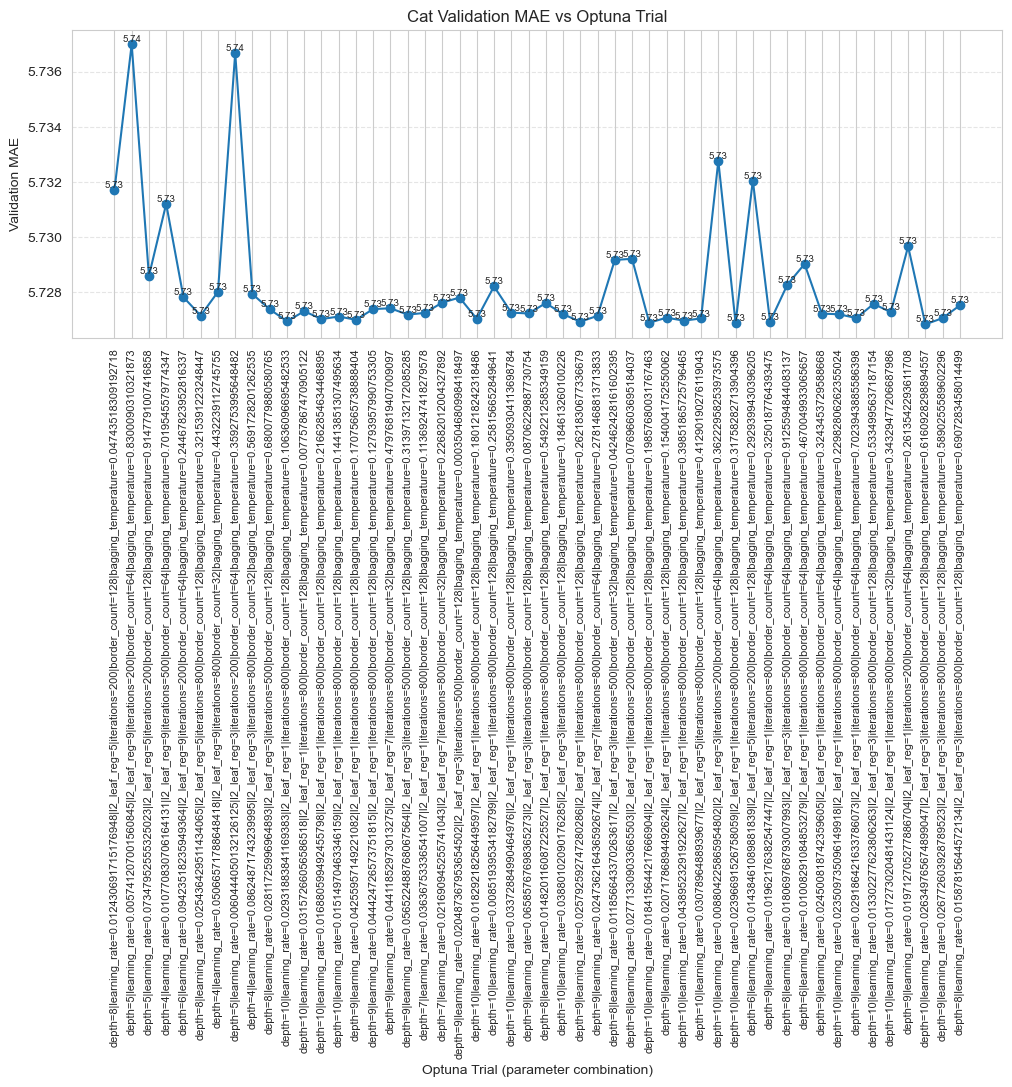

/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/1552823583.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


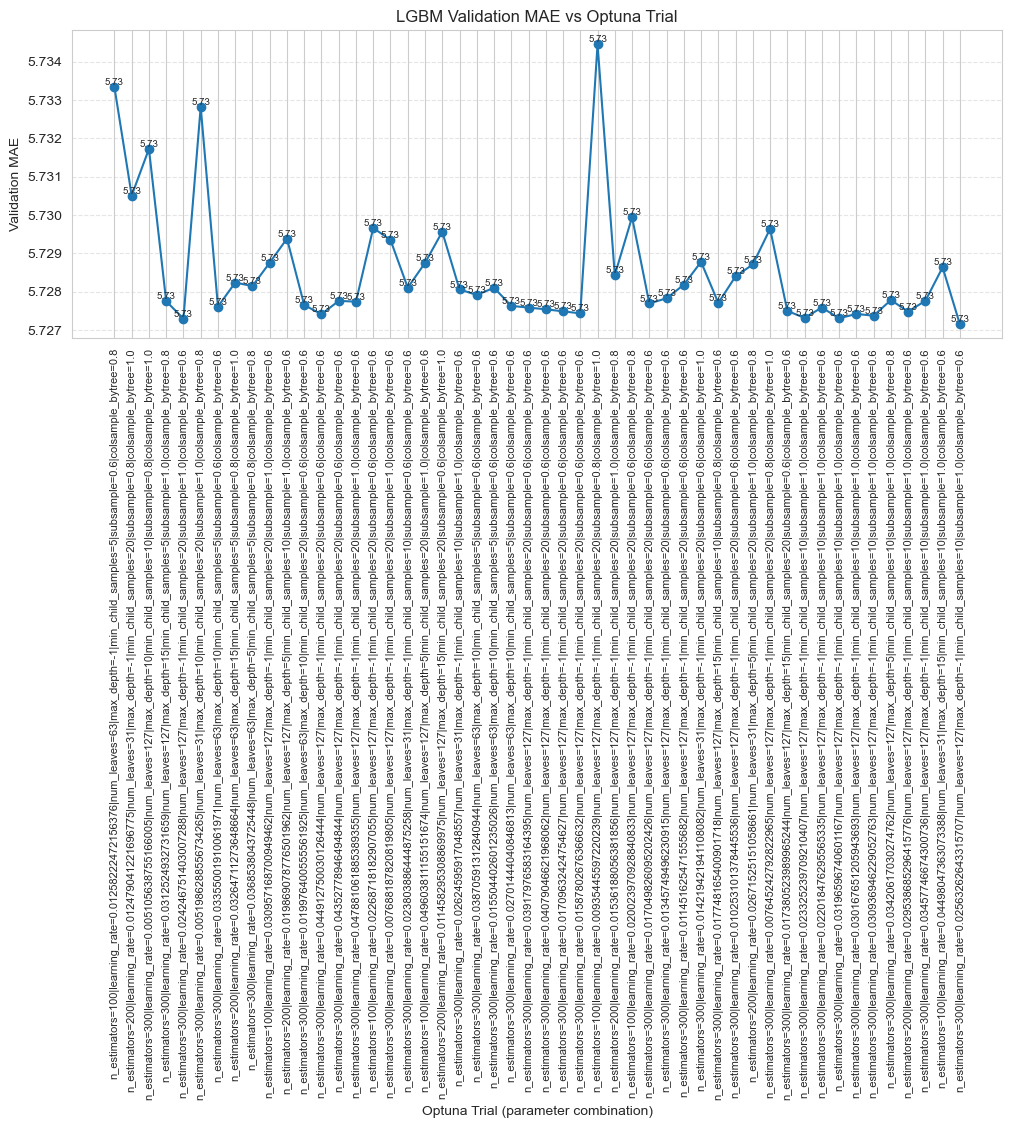

/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/1552823583.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


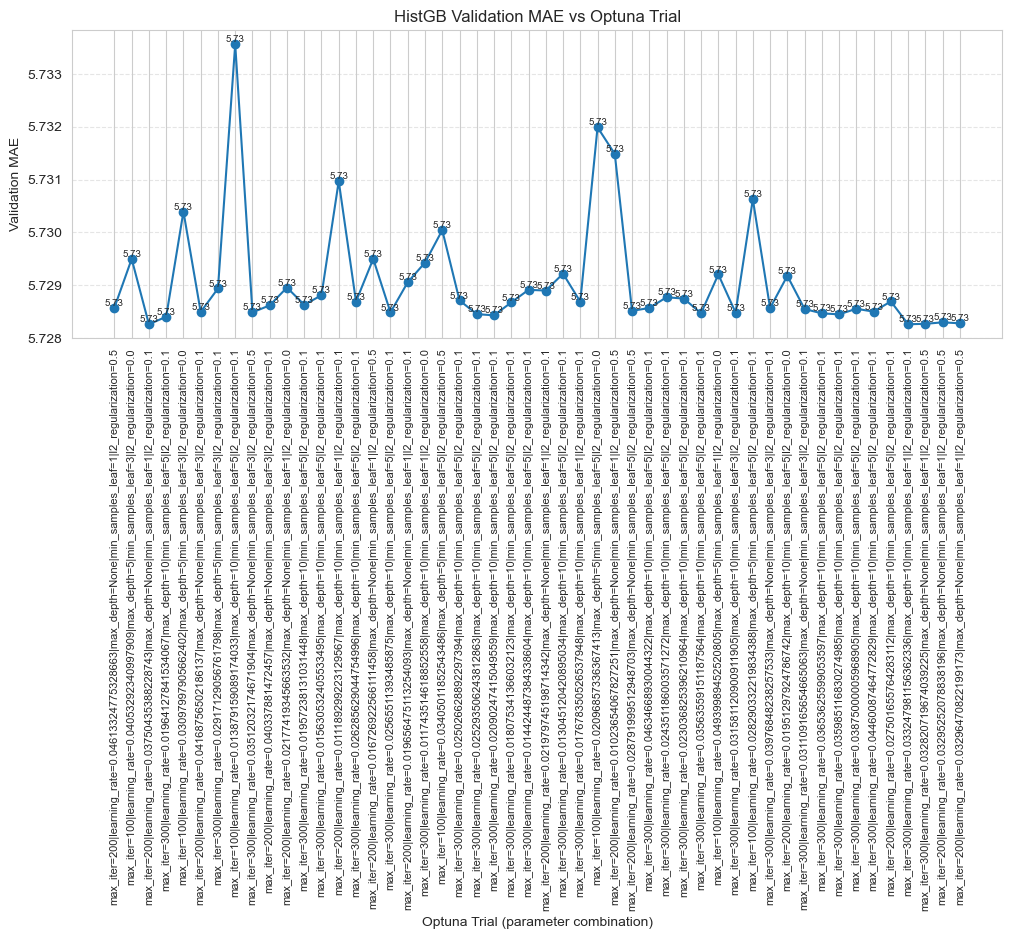

/var/folders/_2/7d52k4j5451f0ytscvrz28k40000gn/T/ipykernel_94106/1552823583.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


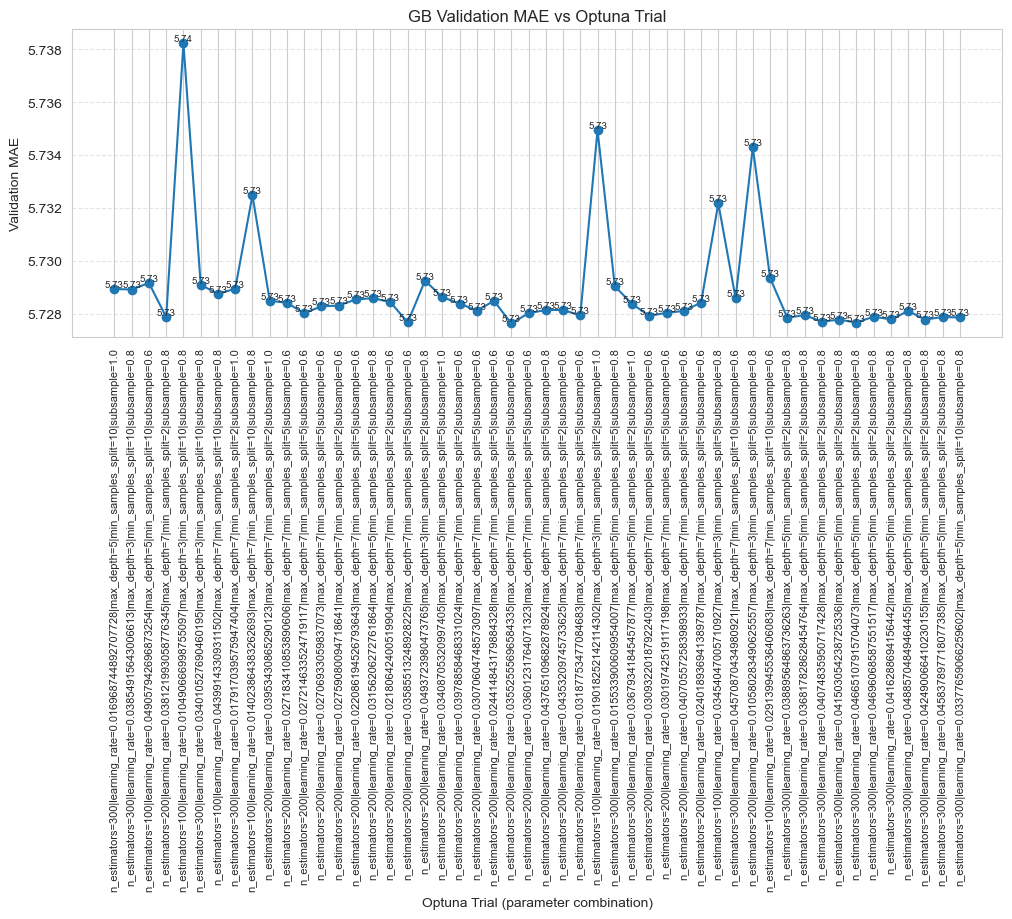

In [42]:
# 하이퍼파라미터 튜닝 시각화

for name, study in studies.items():
    # 1) trials 정보 추출
    records = []
    for t in study.trials:
        # trial.params 는 dict, trial.value 는 validation MAE
        combo = "|".join(f"{k}={v}" for k, v in t.params.items())
        records.append({
            "trial": t.number,
            "validation_MAE": t.value,
            "combo": combo
        })
    df_trials = pd.DataFrame(records)

    # 2) 시각화
    plt.figure(figsize=(12, 4))
    plt.plot(df_trials["trial"], df_trials["validation_MAE"], marker="o", linestyle="-")
    plt.xticks(df_trials["trial"], df_trials["combo"], rotation=90, fontsize=8)
    plt.title(f"{name} Validation MAE vs Optuna Trial")
    plt.xlabel("Optuna Trial (parameter combination)")
    plt.ylabel("Validation MAE")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    for _, row in df_trials.iterrows():
        plt.text(row["trial"], row["validation_MAE"], f"{row['validation_MAE']:.2f}",
                 ha="center", va="bottom", fontsize=7)
    plt.tight_layout()
    plt.show()

In [43]:
best_estimators

{'Cat': <catboost.core.CatBoostRegressor at 0x151ad6d00>,
 'LGBM': LGBMRegressor(colsample_bytree=0.6, learning_rate=0.02563262643315707,
               min_child_samples=10, n_estimators=300, num_leaves=127,
               random_state=42),
 'HistGB': HistGradientBoostingRegressor(l2_regularization=0.1,
                               learning_rate=0.03750435388228743, max_iter=200,
                               min_samples_leaf=1, random_state=42),
 'GB': GradientBoostingRegressor(learning_rate=0.03552555696584335, max_depth=7,
                           min_samples_split=5, n_estimators=200,
                           random_state=42, subsample=0.6)}

In [44]:
cat_params = best_estimators['Cat'].get_params()
print(cat_params)

{'iterations': 800, 'learning_rate': 0.026349765674899047, 'depth': 10, 'l2_leaf_reg': 3, 'loss_function': 'RMSE', 'border_count': 128, 'bagging_temperature': 0.6160928298894557, 'random_state': 42}


In [45]:
df_test

test_MAE      test_MSE
model                            
Cat     2307.615020  1.484223e+08
LGBM    2309.660286  1.484625e+08
GB      2318.436074  1.483157e+08
HistGB  2318.946850  1.485807e+08

In [46]:
# 1) 테스트 MAE 최저 모델 이름
best_model_name = df_test['test_MAE'].idxmin()
best_model = best_estimators[best_model_name]

# 2) Validation MAE (Optuna) 와 Test MAE/MSE (df_test) 가져오기
validation_mae = studies[best_model_name].best_value
test_mae       = df_test.loc[best_model_name, 'test_MAE']
test_mse       = df_test.loc[best_model_name, 'test_MSE']

# 3) 튜닝된 파라미터
tuned_params = studies[best_model_name].best_params

print(f"최종 선택 모델       : {best_model_name}")
print(f"튜닝된 하이퍼파라미터 : {tuned_params}")
print(f"Validation MAE       : {validation_mae:.2f}")
print(f"Test MAE             : {test_mae:.2f}")
print(f"Test MSE             : {test_mse:.4e}")

최종 선택 모델       : Cat
튜닝된 하이퍼파라미터 : {'depth': 10, 'learning_rate': 0.026349765674899047, 'l2_leaf_reg': 3, 'iterations': 800, 'border_count': 128, 'bagging_temperature': 0.6160928298894557}
Validation MAE       : 5.73
Test MAE             : 2307.62
Test MSE             : 1.4842e+08


In [47]:
from itertools import combinations
from sklearn.ensemble import (
    StackingRegressor, VotingRegressor
)

# 앙상블: Stacking & Voting
ensemble_results = []
base_items = list(best_estimators.items())
meta_models = {'Ridge': Ridge(), 'Lasso': Lasso()}

# Stacking 조합
for r in [2, 3]:
    for combo in tqdm(list(combinations(base_items, r)), desc=f"Stacking r={r}", leave=False):
        names, models_ = zip(*combo)
        for meta_name, meta in meta_models.items():
            stack = StackingRegressor(
                estimators=list(zip(names, models_)),
                final_estimator=meta,
                n_jobs=-1
            )
            stack.fit(X_tv_proc, y_tv_proc)
            y_pred = np.expm1(stack.predict(X_test_proc))
            ensemble_results.append({
                'type': f"Stack({'+'.join(names)})/{meta_name}",
                'MAE': mean_absolute_error(y_test, y_pred)
            })

# Voting 조합
for r in [2, 3]:
    for combo in tqdm(list(combinations(base_items, r)), desc=f"Voting r={r}", leave=False):
        names, models_ = zip(*combo)
        vote = VotingRegressor(estimators=list(zip(names, models_)), n_jobs=-1)
        vote.fit(X_tv_proc, y_tv_proc)
        y_pred = np.expm1(vote.predict(X_test_proc))
        ensemble_results.append({
            'type': f"Vote({'+'.join(names)})",
            'MAE': mean_absolute_error(y_test, y_pred)
        })

# 결과 정리 및 출력
df_ens = pd.DataFrame(ensemble_results).sort_values('MAE').reset_index(drop=True)
pd.set_option('display.max_rows', None)
print("\n=== Ensemble Results ===")
print(df_ens.to_string(index=False))

Stacking r=2:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8478
[LightGBM] [Info] Number of data points in the train set: 31400, number of used features: 59
[LightGBM] [Info] Start training from score 7.440042
0:	learn: 0.8597147	total: 66.1ms	remaining: 52.8s
1:	learn: 0.8568249	total: 73.2ms	remaining: 29.2s
2:	learn: 0.8543829	total: 79.4ms	remaining: 21.1s
3:	learn: 0.8518136	total: 85.8ms	remaining: 17.1s
4:	learn: 0.8493139	total: 92.4ms	remaining: 14.7s
5:	learn: 0.8470308	total: 98.8ms	remaining: 13.1s
6:	learn: 0.8449287	total: 105ms	remaining: 11.9s
7:	learn: 0.8427979	total: 112ms	remaining: 11.1s
8:	learn: 0.8407414	total: 119ms	remaining: 10.4s
9:	learn: 0.8388733	total: 125ms	remaining: 9.88s
10:	lear

Stacking r=2:  17%|█▋        | 1/6 [02:13<11:07, 133.52s/it]

0:	learn: 0.8597147	total: 25.7ms	remaining: 20.6s
1:	learn: 0.8568249	total: 59.9ms	remaining: 23.9s
2:	learn: 0.8543829	total: 92.5ms	remaining: 24.6s
3:	learn: 0.8518136	total: 181ms	remaining: 36s
4:	learn: 0.8493139	total: 190ms	remaining: 30.2s
5:	learn: 0.8470308	total: 197ms	remaining: 26.1s
6:	learn: 0.8449287	total: 204ms	remaining: 23.2s
7:	learn: 0.8427979	total: 212ms	remaining: 21s
8:	learn: 0.8407414	total: 219ms	remaining: 19.2s
9:	learn: 0.8388733	total: 226ms	remaining: 17.9s
10:	learn: 0.8368282	total: 241ms	remaining: 17.3s
11:	learn: 0.8349230	total: 254ms	remaining: 16.7s
12:	learn: 0.8331462	total: 264ms	remaining: 16s
13:	learn: 0.8313503	total: 271ms	remaining: 15.2s
14:	learn: 0.8297040	total: 278ms	remaining: 14.6s
15:	learn: 0.8280008	total: 287ms	remaining: 14.1s
16:	learn: 0.8263756	total: 302ms	remaining: 13.9s
17:	learn: 0.8248242	total: 310ms	remaining: 13.5s
18:	learn: 0.8234120	total: 317ms	remaining: 13s
19:	learn: 0.8219655	total: 323ms	remaining: 1

Stacking r=2:  33%|███▎      | 2/6 [03:03<05:37, 84.33s/it] 

0:	learn: 0.8597147	total: 27ms	remaining: 21.5s
1:	learn: 0.8568249	total: 47.2ms	remaining: 18.8s
2:	learn: 0.8543829	total: 70.7ms	remaining: 18.8s
3:	learn: 0.8518136	total: 90.4ms	remaining: 18s
4:	learn: 0.8493139	total: 111ms	remaining: 17.6s
5:	learn: 0.8470308	total: 132ms	remaining: 17.5s
6:	learn: 0.8449287	total: 193ms	remaining: 21.8s
7:	learn: 0.8427979	total: 199ms	remaining: 19.7s
8:	learn: 0.8407414	total: 206ms	remaining: 18.1s
9:	learn: 0.8388733	total: 213ms	remaining: 16.8s
10:	learn: 0.8368282	total: 219ms	remaining: 15.7s
11:	learn: 0.8349230	total: 227ms	remaining: 14.9s
12:	learn: 0.8331462	total: 236ms	remaining: 14.3s
13:	learn: 0.8313503	total: 254ms	remaining: 14.3s
14:	learn: 0.8297040	total: 262ms	remaining: 13.7s
15:	learn: 0.8280008	total: 269ms	remaining: 13.2s
16:	learn: 0.8263756	total: 277ms	remaining: 12.7s
17:	learn: 0.8248242	total: 284ms	remaining: 12.3s
18:	learn: 0.8234120	total: 291ms	remaining: 12s
19:	learn: 0.8219655	total: 298ms	remaining

Stacking r=2:  50%|█████     | 3/6 [06:24<06:52, 137.55s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8478
[LightGBM] [Info] Number of data points in the train set: 31400, number of used features: 59
[LightGBM] [Info] Start training from score 7.440042
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

Stacking r=2:  67%|██████▋   | 4/6 [07:59<04:01, 120.90s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8478
[LightGBM] [Info] Number of data points in the train set: 31400, number of used features: 59
[LightGBM] [Info] Start training from score 7.440042
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

Stacking r=3:   0%|          | 0/4 [00:00<?, ?it/s]         

0:	learn: 0.8597147	total: 65.5ms	remaining: 52.4s
1:	learn: 0.8568249	total: 74.4ms	remaining: 29.7s
2:	learn: 0.8543829	total: 81.3ms	remaining: 21.6s
3:	learn: 0.8518136	total: 89.1ms	remaining: 17.7s
4:	learn: 0.8493139	total: 96.3ms	remaining: 15.3s
5:	learn: 0.8470308	total: 104ms	remaining: 13.7s
6:	learn: 0.8449287	total: 110ms	remaining: 12.5s
7:	learn: 0.8427979	total: 117ms	remaining: 11.6s
8:	learn: 0.8407414	total: 124ms	remaining: 10.9s
9:	learn: 0.8388733	total: 131ms	remaining: 10.3s
10:	learn: 0.8368282	total: 138ms	remaining: 9.89s
11:	learn: 0.8349230	total: 145ms	remaining: 9.51s
12:	learn: 0.8331462	total: 152ms	remaining: 9.23s
13:	learn: 0.8313503	total: 160ms	remaining: 8.99s
14:	learn: 0.8297040	total: 168ms	remaining: 8.8s
15:	learn: 0.8280008	total: 175ms	remaining: 8.58s
16:	learn: 0.8263756	total: 183ms	remaining: 8.41s
17:	learn: 0.8248242	total: 191ms	remaining: 8.3s
18:	learn: 0.8234120	total: 199ms	remaining: 8.18s
19:	learn: 0.8219655	total: 206ms	rema

Stacking r=3:  25%|██▌       | 1/4 [02:13<06:40, 133.42s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8478
[LightGBM] [Info] Number of data points in the train set: 31400, number of used features: 59
[LightGBM] [Info] Start training from score 7.440042
0:	learn: 0.8597147	total: 69.9ms	remaining: 55.9s
1:	learn: 0.8568249	total: 82.7ms	remaining: 33s
2:	learn: 0.8543829	total: 93.3ms	remaining: 24.8s
3:	learn: 0.8518136	total: 104ms	remaining: 20.8s
4:	learn: 0.8493139	total: 115ms	remaining: 18.2s
5:	learn: 0.8470308	total: 125ms	remaining: 16.6s
6:	learn: 0.8449287	total: 136ms	remaining: 15.4s
7:	learn: 0.8427979	total: 146ms	remaining: 14.5s
8:	learn: 0.8407414	total: 157ms	remaining: 13.8s
9:	learn: 0.8388733	total: 167ms	remaining: 13.2s
10:	learn: 0.8368282	total: 177ms	remaining: 12.7s
11:	learn: 0.8349230	total

Stacking r=3:  50%|█████     | 2/4 [06:36<06:59, 209.56s/it]

0:	learn: 0.8597147	total: 13.1ms	remaining: 10.4s
1:	learn: 0.8568249	total: 21.2ms	remaining: 8.47s
2:	learn: 0.8543829	total: 29.5ms	remaining: 7.84s
3:	learn: 0.8518136	total: 38.2ms	remaining: 7.61s
4:	learn: 0.8493139	total: 46.6ms	remaining: 7.42s
5:	learn: 0.8470308	total: 55.4ms	remaining: 7.34s
6:	learn: 0.8449287	total: 63.6ms	remaining: 7.2s
7:	learn: 0.8427979	total: 72ms	remaining: 7.12s
8:	learn: 0.8407414	total: 80.2ms	remaining: 7.05s
9:	learn: 0.8388733	total: 88.7ms	remaining: 7s
10:	learn: 0.8368282	total: 99.1ms	remaining: 7.11s
11:	learn: 0.8349230	total: 111ms	remaining: 7.31s
12:	learn: 0.8331462	total: 123ms	remaining: 7.44s
13:	learn: 0.8313503	total: 134ms	remaining: 7.5s
14:	learn: 0.8297040	total: 141ms	remaining: 7.4s
15:	learn: 0.8280008	total: 150ms	remaining: 7.33s
16:	learn: 0.8263756	total: 158ms	remaining: 7.28s
17:	learn: 0.8248242	total: 166ms	remaining: 7.23s
18:	learn: 0.8234120	total: 175ms	remaining: 7.18s
19:	learn: 0.8219655	total: 183ms	rema

Stacking r=3:  75%|███████▌  | 3/4 [09:59<03:26, 206.77s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8478
[LightGBM] [Info] Number of data points in the train set: 31400, number of used features: 59
[LightGBM] [Info] Start training from score 7.440042
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050174 seconds.
You can se

Voting r=2:   0%|          | 0/6 [00:00<?, ?it/s]           

0:	learn: 0.8597147	total: 20.7ms	remaining: 16.5s
1:	learn: 0.8568249	total: 39.7ms	remaining: 15.9s
2:	learn: 0.8543829	total: 57.7ms	remaining: 15.3s
3:	learn: 0.8518136	total: 76.6ms	remaining: 15.2s
4:	learn: 0.8493139	total: 94.6ms	remaining: 15s
5:	learn: 0.8470308	total: 110ms	remaining: 14.6s
6:	learn: 0.8449287	total: 125ms	remaining: 14.2s
7:	learn: 0.8427979	total: 173ms	remaining: 17.1s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
8:	learn: 0.8407414	total: 188ms	remaining: 16.5s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8478
[LightGBM] [Info] Number of data points in the train set: 31400, number of used features: 59
9:	learn: 0.8388733	total: 196ms	remaining: 15.5s
[LightGBM] [Info] Start training from score 7.440042
10:	learn: 0.8368282	total: 202ms	remaining: 14.5s
11:	learn: 0.8349230	tot

Voting r=2:  17%|█▋        | 1/6 [00:08<00:42,  8.54s/it]

0:	learn: 0.8597147	total: 13.4ms	remaining: 10.7s
1:	learn: 0.8568249	total: 23ms	remaining: 9.18s
2:	learn: 0.8543829	total: 31.3ms	remaining: 8.31s
3:	learn: 0.8518136	total: 39.2ms	remaining: 7.8s
4:	learn: 0.8493139	total: 46.9ms	remaining: 7.46s
5:	learn: 0.8470308	total: 54ms	remaining: 7.14s
6:	learn: 0.8449287	total: 61.1ms	remaining: 6.93s
7:	learn: 0.8427979	total: 67.8ms	remaining: 6.71s
8:	learn: 0.8407414	total: 74.4ms	remaining: 6.54s
9:	learn: 0.8388733	total: 80.8ms	remaining: 6.38s
10:	learn: 0.8368282	total: 88ms	remaining: 6.31s
11:	learn: 0.8349230	total: 94.9ms	remaining: 6.23s
12:	learn: 0.8331462	total: 102ms	remaining: 6.19s
13:	learn: 0.8313503	total: 109ms	remaining: 6.14s
14:	learn: 0.8297040	total: 117ms	remaining: 6.14s
15:	learn: 0.8280008	total: 125ms	remaining: 6.14s
16:	learn: 0.8263756	total: 134ms	remaining: 6.18s
17:	learn: 0.8248242	total: 142ms	remaining: 6.17s
18:	learn: 0.8234120	total: 149ms	remaining: 6.13s
19:	learn: 0.8219655	total: 156ms	re

Voting r=2:  33%|███▎      | 2/6 [00:14<00:28,  7.06s/it]

0:	learn: 0.8597147	total: 65.8ms	remaining: 52.6s
1:	learn: 0.8568249	total: 75.4ms	remaining: 30.1s
2:	learn: 0.8543829	total: 84.4ms	remaining: 22.4s
3:	learn: 0.8518136	total: 93ms	remaining: 18.5s
4:	learn: 0.8493139	total: 99.8ms	remaining: 15.9s
5:	learn: 0.8470308	total: 107ms	remaining: 14.1s
6:	learn: 0.8449287	total: 114ms	remaining: 12.9s
7:	learn: 0.8427979	total: 121ms	remaining: 11.9s
8:	learn: 0.8407414	total: 129ms	remaining: 11.3s
9:	learn: 0.8388733	total: 136ms	remaining: 10.7s
10:	learn: 0.8368282	total: 143ms	remaining: 10.3s
11:	learn: 0.8349230	total: 150ms	remaining: 9.88s
12:	learn: 0.8331462	total: 158ms	remaining: 9.55s
13:	learn: 0.8313503	total: 165ms	remaining: 9.26s
14:	learn: 0.8297040	total: 172ms	remaining: 8.99s
15:	learn: 0.8280008	total: 179ms	remaining: 8.78s
16:	learn: 0.8263756	total: 186ms	remaining: 8.58s
17:	learn: 0.8248242	total: 193ms	remaining: 8.39s
18:	learn: 0.8234120	total: 200ms	remaining: 8.24s
19:	learn: 0.8219655	total: 208ms	rema

Voting r=2:  50%|█████     | 3/6 [01:04<01:19, 26.48s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8478
[LightGBM] [Info] Number of data points in the train set: 31400, number of used features: 59
[LightGBM] [Info] Start training from score 7.440042


Voting r=2:  67%|██████▋   | 4/6 [01:09<00:35, 17.98s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8478
[LightGBM] [Info] Number of data points in the train set: 31400, number of used features: 59
[LightGBM] [Info] Start training from score 7.440042


Voting r=3:   0%|          | 0/4 [00:00<?, ?it/s]        

0:	learn: 0.8597147	total: 7.59ms	remaining: 6.06s
1:	learn: 0.8568249	total: 15.1ms	remaining: 6s
2:	learn: 0.8543829	total: 27.6ms	remaining: 7.34s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
3:	learn: 0.8518136	total: 38.4ms	remaining: 7.64s
4:	learn: 0.8493139	total: 47ms	remaining: 7.47s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8478
[LightGBM] [Info] Number of data points in the train set: 31400, number of used features: 59
[LightGBM] [Info] Start training from score 7.440042
5:	learn: 0.8470308	total: 57.2ms	remaining: 7.56s
6:	learn: 0.8449287	total: 65.3ms	remaining: 7.39s
7:	learn: 0.8427979	total: 73ms	remaining: 7.22s
8:	learn: 0.8407414	total: 80.7ms	remaining: 7.09s
9:	learn: 0.8388733	total: 88.3ms	remaining: 6.97s
10:	learn: 

Voting r=3:  25%|██▌       | 1/4 [00:08<00:26,  8.83s/it]

0:	learn: 0.8597147	total: 15.5ms	remaining: 12.4s
1:	learn: 0.8568249	total: 24.6ms	remaining: 9.82s
2:	learn: 0.8543829	total: 33.2ms	remaining: 8.82s
3:	learn: 0.8518136	total: 41.4ms	remaining: 8.23s
4:	learn: 0.8493139	total: 49.4ms	remaining: 7.86s
5:	learn: 0.8470308	total: 56.8ms	remaining: 7.52s
6:	learn: 0.8449287	total: 65ms	remaining: 7.36s
7:	learn: 0.8427979	total: 73ms	remaining: 7.23s
8:	learn: 0.8407414	total: 81.1ms	remaining: 7.13s
9:	learn: 0.8388733	total: 88.4ms	remaining: 6.98s
10:	learn: 0.8368282	total: 95.5ms	remaining: 6.85s
11:	learn: 0.8349230	total: 104ms	remaining: 6.81s
12:	learn: 0.8331462	total: 111ms	remaining: 6.72s
13:	learn: 0.8313503	total: 118ms	remaining: 6.65s
14:	learn: 0.8297040	total: 126ms	remaining: 6.58s
15:	learn: 0.8280008	total: 135ms	remaining: 6.59s
16:	learn: 0.8263756	total: 142ms	remaining: 6.53s
17:	learn: 0.8248242	total: 149ms	remaining: 6.47s
18:	learn: 0.8234120	total: 157ms	remaining: 6.44s
19:	learn: 0.8219655	total: 174ms	

Voting r=3:  50%|█████     | 2/4 [00:58<01:05, 32.57s/it]

0:	learn: 0.8597147	total: 23.7ms	remaining: 18.9s
1:	learn: 0.8568249	total: 36.5ms	remaining: 14.6s
2:	learn: 0.8543829	total: 47.1ms	remaining: 12.5s
3:	learn: 0.8518136	total: 59.5ms	remaining: 11.8s
4:	learn: 0.8493139	total: 69.3ms	remaining: 11s
5:	learn: 0.8470308	total: 77.6ms	remaining: 10.3s
6:	learn: 0.8449287	total: 84.7ms	remaining: 9.59s
7:	learn: 0.8427979	total: 91.5ms	remaining: 9.05s
8:	learn: 0.8407414	total: 100ms	remaining: 8.83s
9:	learn: 0.8388733	total: 108ms	remaining: 8.49s
10:	learn: 0.8368282	total: 115ms	remaining: 8.28s
11:	learn: 0.8349230	total: 122ms	remaining: 8.03s
12:	learn: 0.8331462	total: 129ms	remaining: 7.82s
13:	learn: 0.8313503	total: 139ms	remaining: 7.82s
14:	learn: 0.8297040	total: 147ms	remaining: 7.7s
15:	learn: 0.8280008	total: 154ms	remaining: 7.57s
16:	learn: 0.8263756	total: 162ms	remaining: 7.44s
17:	learn: 0.8248242	total: 169ms	remaining: 7.34s
18:	learn: 0.8234120	total: 176ms	remaining: 7.24s
19:	learn: 0.8219655	total: 183ms	re

Voting r=3:  75%|███████▌  | 3/4 [01:47<00:40, 40.43s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8478
[LightGBM] [Info] Number of data points in the train set: 31400, number of used features: 59
[LightGBM] [Info] Start training from score 7.440042



=== Ensemble Results ===
                        type         MAE
Stack(Cat+LGBM+HistGB)/Ridge 2305.608262
       Stack(Cat+LGBM)/Ridge 2305.608683
    Stack(Cat+LGBM+GB)/Ridge 2305.756546
              Vote(Cat+LGBM) 2305.901900
  Stack(Cat+HistGB+GB)/Ridge 2307.264067
         Stack(Cat+GB)/Ridge 2307.360007
     Stack(Cat+HistGB)/Ridge 2307.394845
           Vote(Cat+LGBM+GB) 2307.763647
       Vote(Cat+LGBM+HistGB) 2307.770173
    Stack(LGBM+HistGB)/Ridge 2308.673382
 Stack(LGBM+HistGB+GB)/Ridge 2308.687062
        Stack(LGBM+GB)/Ridge 2308.921339
                Vote(Cat+GB) 2309.248578
            Vote(Cat+HistGB) 2309.631070
         Vote(Cat+HistGB+GB) 2310.071171
               Vote(LGBM+GB) 2310.976415
           Vote(LGBM+HistGB) 2311.081254
        Vote(LGBM+HistGB+GB) 2311.326396
      Stack(HistGB+GB)/Ridge 2313.991788
             Vote(HistGB+GB) 2315.058819
    Stack(Cat+LGBM+GB)/Lasso 2450.819718
 Stack(LGBM+HistGB+GB)/Lasso 2450.819718
Stack(Cat+LGBM+HistGB)/Lasso 24

In [50]:
best_ens = df_ens.iloc[0]
print(f"최종 앙상블: {best_ens['type']}  (Test MAE: {best_ens['MAE']:.2f})")

최종 앙상블: Stack(Cat+LGBM+HistGB)/Ridge  (Test MAE: 2305.61)
